In [1]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10.0/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0 MB 11 kB/s 
     |████████████████████████████████| 5.9 MB 23.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.6.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.6.0+cu101 which is incompatible.
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6

In [2]:
!rm -r -f test-bench/ __MACOSX/
!unzip drive/MyDrive/nti2022/final/test-bench.zip -x "__MACOSX/*"

Archive:  drive/MyDrive/nti2022/final/test-bench.zip
   creating: test-bench/
  inflating: test-bench/recognition-baseline-plus-50-epoch.pth  
  inflating: test-bench/.DS_Store    
   creating: test-bench/images/
  inflating: test-bench/best-qual-seg-model.pth  
  inflating: test-bench/best-qual-recognition-ru-model.pth  
  inflating: test-bench/images/0_3_eng.jpg  
  inflating: test-bench/images/.DS_Store  
  inflating: test-bench/images/0_2_eng.jpg  
  inflating: test-bench/images/0_0_eng.jpg  
  inflating: test-bench/images/0_1_eng.jpg  
  inflating: test-bench/images/41_0.JPG  
  inflating: test-bench/images/0_4_eng.jpg  
  inflating: test-bench/images/41_1.JPG  
  inflating: test-bench/images/41_3.JPG  
  inflating: test-bench/images/41_2.JPG  
  inflating: test-bench/images/41_6.JPG  
  inflating: test-bench/images/41_7.JPG  
  inflating: test-bench/images/41_5.JPG  
  inflating: test-bench/images/0_5_eng.jpg  
  inflating: test-bench/images/41_4.JPG  
  inflating: test-bench/ima

In [3]:
import json
import logging
import os
import sys
import warnings

import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision
from PIL import ImageFont, ImageDraw, Image
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from tqdm import tqdm

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams["figure.dpi"] = 120

In [4]:
logger = logging.getLogger('detectron2')
logger.setLevel(logging.CRITICAL)

# Hot fix for read-only error on /root/.cache/torch
torch.hub.set_dir('torch_cache/')

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

TEST_IMAGES_PATH, SAVE_JSON_PATH = sys.argv[1:]

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEGM_MODEL_PATH = 'best-qual-seg-model.pth'
OCR_MODEL_PATH = 'recognition-baseline-plus-50-epoch.pth'

CONFIG_JSON = {
    "alphabet": ''' !"%\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPRSTUVWXY[]_abcdefghijklmnopqrstuvwxyz|}ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№''',
    "image": {
        "width": 256,
        "height": 32
    }
}


def get_contours_from_mask(mask, min_area=5):
    contours, hierarchy = cv2.findContours(mask.astype(np.uint8),
                                           cv2.RETR_LIST,
                                           cv2.CHAIN_APPROX_SIMPLE)
    contour_list = []
    for contour in contours:
        if cv2.contourArea(contour) >= min_area:
            contour_list.append(contour)
    return contour_list


def get_larger_contour(contours):
    larger_area = 0
    larger_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > larger_area:
            larger_contour = contour
            larger_area = area
    return larger_contour


class SEGMpredictor:
    def __init__(self, model_path):
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
        cfg.MODEL.WEIGHTS = model_path
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
        cfg.INPUT.MIN_SIZE_TEST = 800
        cfg.INPUT.MAX_SIZE_TEST = 1333
        cfg.INPUT.FORMAT = "BGR"
        cfg.TEST.DETECTIONS_PER_IMAGE = 3000

        self.predictor = DefaultPredictor(cfg)

    def __call__(self, img):
        outputs = self.predictor(img)
        prediction = outputs['instances'].pred_masks.cpu().numpy()
        contours = []
        for pred in prediction:
            contour_list = get_contours_from_mask(pred)
            contours.append(get_larger_contour(contour_list))
        return contours




def crop_img_by_polygon(img, polygon):
    # https://stackoverflow.com/questions/48301186/cropping-concave-polygon-from-image-using-opencv-python
    pts = np.array(polygon)
    rect = cv2.boundingRect(pts)
    x, y, w, h = rect
    croped = img[y:y + h, x:x + w].copy()
    pts = pts - pts.min(axis=0)
    mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
    dst = cv2.bitwise_and(croped, croped, mask=mask)
    return dst




In [5]:
OOV_TOKEN = '<OOV>'
CTC_BLANK = '<BLANK>'


def get_char_map(alphabet):
    """Make from string alphabet character2int dict.
    Add BLANK char fro CTC loss and OOV char for out of vocabulary symbols."""
    char_map = {value: idx + 2 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    char_map[OOV_TOKEN] = 1
    return char_map


class Tokenizer:
    """Class for encoding and decoding string word to sequence of int
    (and vice versa) using alphabet."""

    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        """Returns a list of encoded words (int)."""
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else self.char_map[OOV_TOKEN]
                 for char in word]
            )
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        """Returns a list of words (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                # skip if blank symbol, oov token or repeated characters
                if (
                        char_enc != self.char_map[OOV_TOKEN]
                        and char_enc != self.char_map[CTC_BLANK]
                        # idx > 0 to avoid selecting [-1] item
                        and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words


class Normalize:
    def __call__(self, img):
        img = img.astype(np.float32) / 255
        return img


class ToTensor:
    def __call__(self, arr):
        arr = torch.from_numpy(arr)
        return arr


class MoveChannels:
    """Move the channel axis to the zero position as required in pytorch."""

    def __init__(self, to_channels_first=True):
        self.to_channels_first = to_channels_first

    def __call__(self, image):
        if self.to_channels_first:
            return np.moveaxis(image, -1, 0)
        else:
            return np.moveaxis(image, 0, -1)


class ImageResize:
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, image):
        image = cv2.resize(image, (self.width, self.height),
                           interpolation=cv2.INTER_LINEAR)
        return image


def get_val_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        ImageResize(height, width),
        MoveChannels(to_channels_first=True),
        Normalize(),
        ToTensor()
    ])
    return transforms


def get_resnet34_backbone(pretrained=True):
    m = torchvision.models.resnet34(pretrained=False)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu,
              m.maxpool, m.layer1, m.layer2, m.layer3]
    return nn.Sequential(*blocks)


class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out


class CRNN(nn.Module):
    def __init__(
            self, number_class_symbols, time_feature_count=256, lstm_hidden=256,
            lstm_len=2,
    ):
        super().__init__()
        self.feature_extractor = get_resnet34_backbone(pretrained=True)
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (time_feature_count, time_feature_count))
        self.bilstm = BiLSTM(time_feature_count, lstm_hidden, lstm_len)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, time_feature_count),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(time_feature_count, number_class_symbols)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.bilstm(x)
        x = self.classifier(x)
        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)
        return x


def predict(images, model, tokenizer, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    return text_preds


class InferenceTransform:
    def __init__(self, height, width):
        self.transforms = get_val_transforms(height, width)

    def __call__(self, images):
        transformed_images = []
        for image in images:
            image = self.transforms(image)
            transformed_images.append(image)
        transformed_tensor = torch.stack(transformed_images, 0)
        return transformed_tensor


class OcrPredictor:
    def __init__(self, model_path, config, device='cuda'):
        self.tokenizer = Tokenizer(config['alphabet'])
        self.device = torch.device(device)
        # load model
        self.model = CRNN(number_class_symbols=self.tokenizer.get_num_chars())
        self.model.load_state_dict(torch.load(model_path))
        self.model.to(self.device)

        self.transforms = InferenceTransform(
            height=config['image']['height'],
            width=config['image']['width'],
        )

    def __call__(self, images):
        if isinstance(images, (list, tuple)):
            one_image = False
        elif isinstance(images, np.ndarray):
            images = [images]
            one_image = True
        else:
            raise Exception(f"Input must contain np.ndarray, "
                            f"tuple or list, found {type(images)}.")

        images = self.transforms(images)
        pred = predict(images, self.model, self.tokenizer, self.device)

        if one_image:
            return pred[0]
        else:
            return pred

# Multi-lang model

In [6]:
!rm -f -r torch_cache/

In [7]:
segm_model = SEGMpredictor('test-bench/best-qual-seg-model.pth')
rec_model = OcrPredictor(model_path='test-bench/recognition-baseline-plus-50-epoch.pth', config=CONFIG_JSON)

In [8]:
def eval_img(img_path):
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.show()

    countures = segm_model(img)
    print(f'{len(countures)} found on this image')

    for counture in countures[:10] + countures[-10:]:
        crop_img = crop_img_by_polygon(img, counture)
        text_pred = rec_model(crop_img)
        plt.title(f'Pred text: {text_pred}')
        plt.imshow(crop_img)
        plt.show()


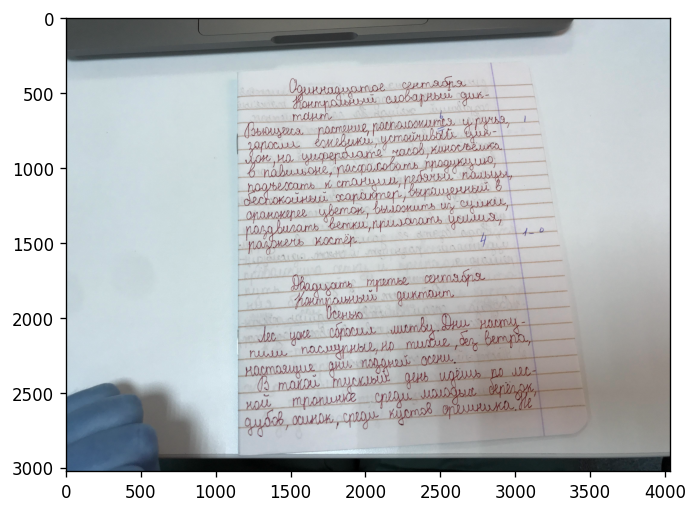

96 found on this image


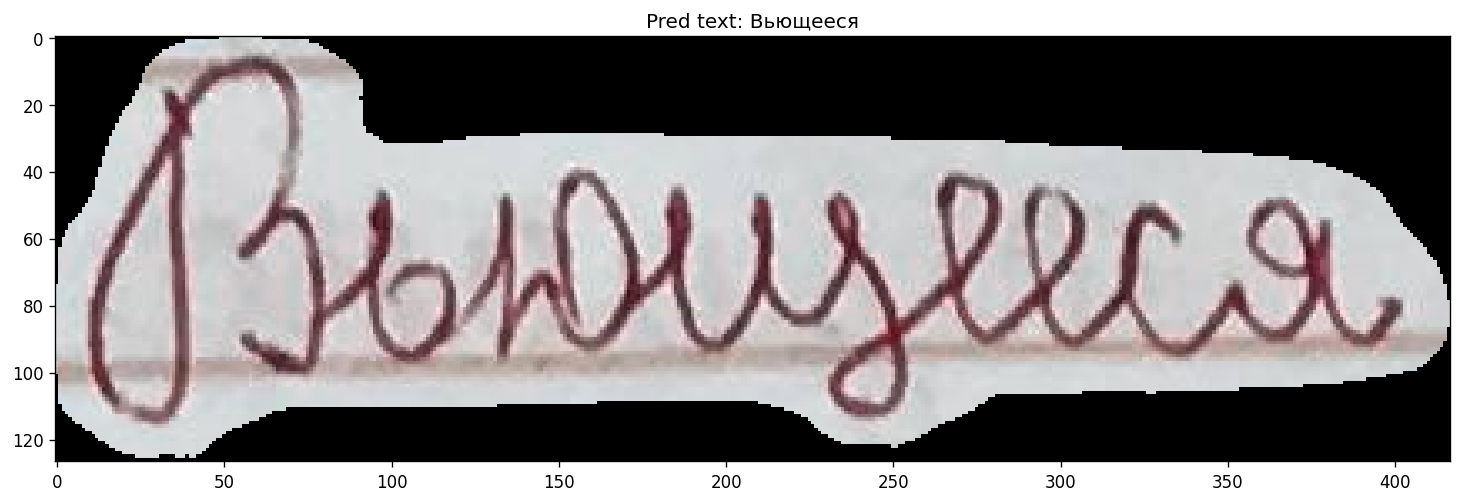

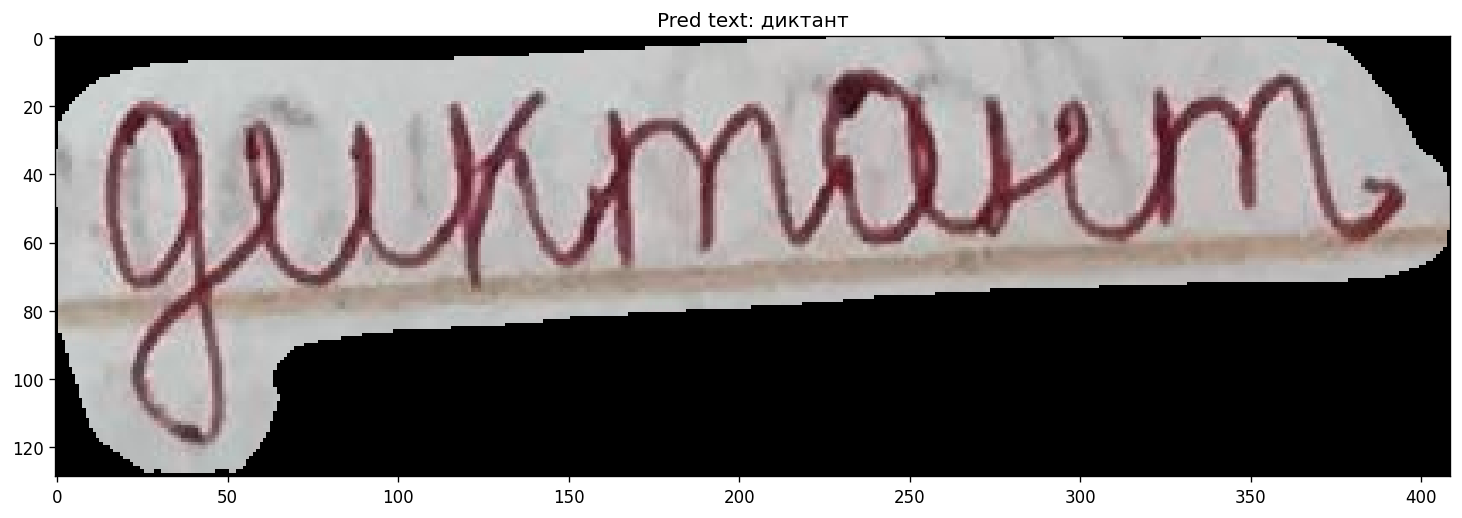

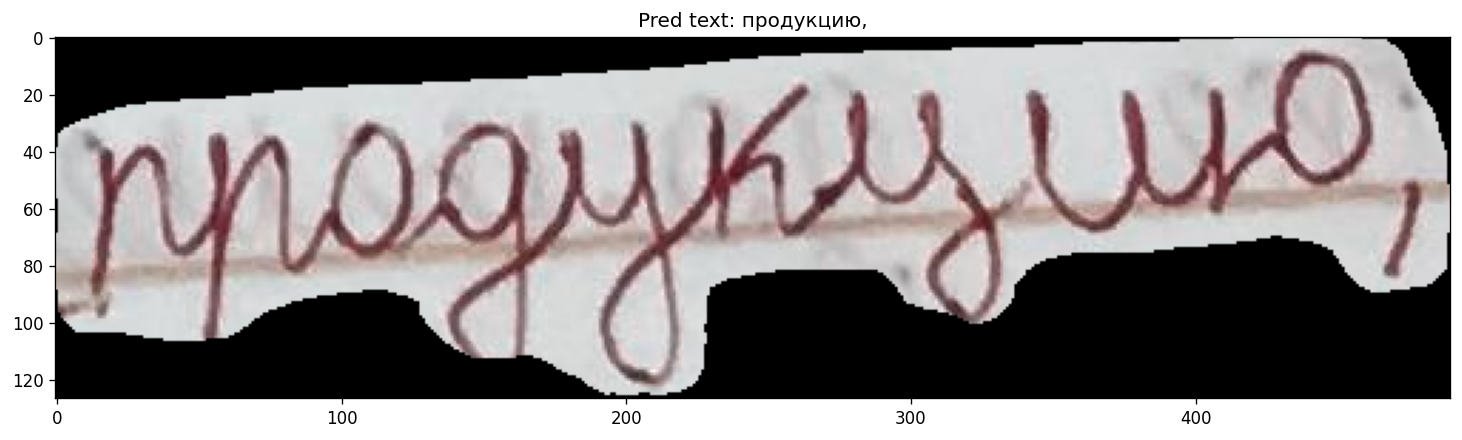

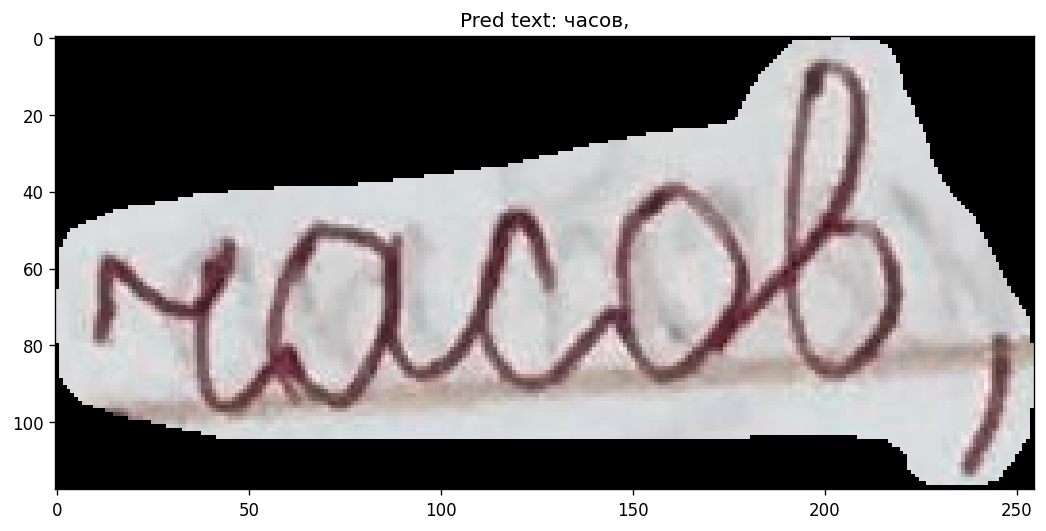

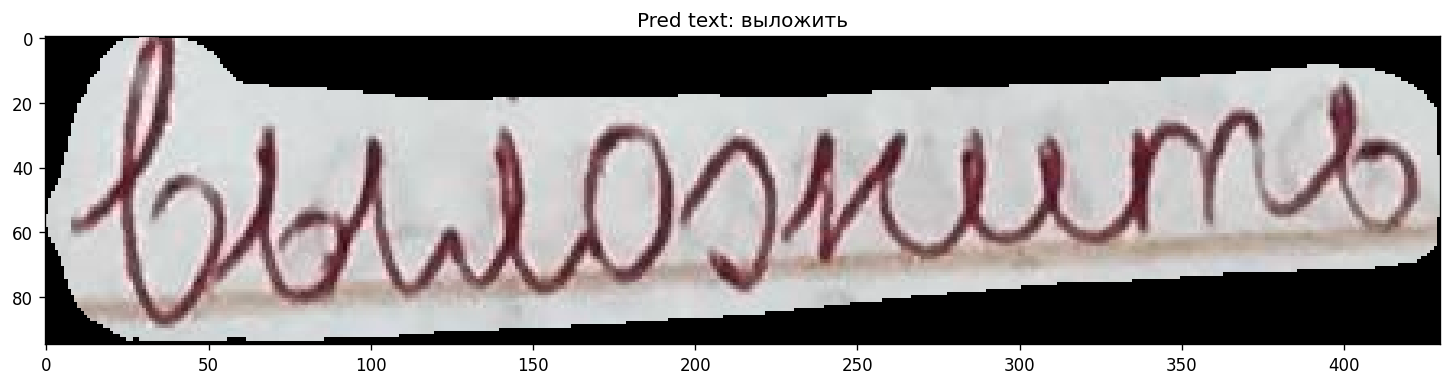

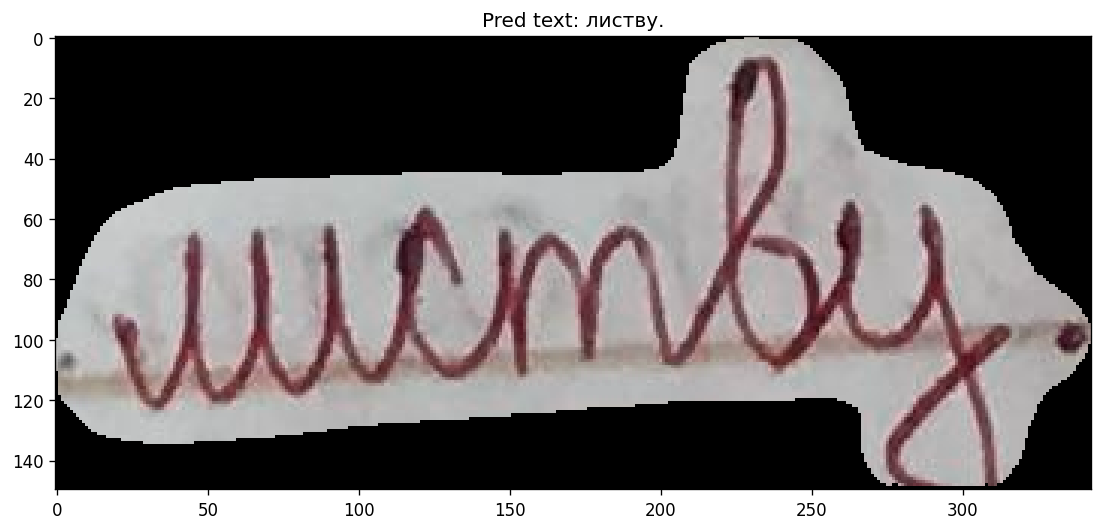

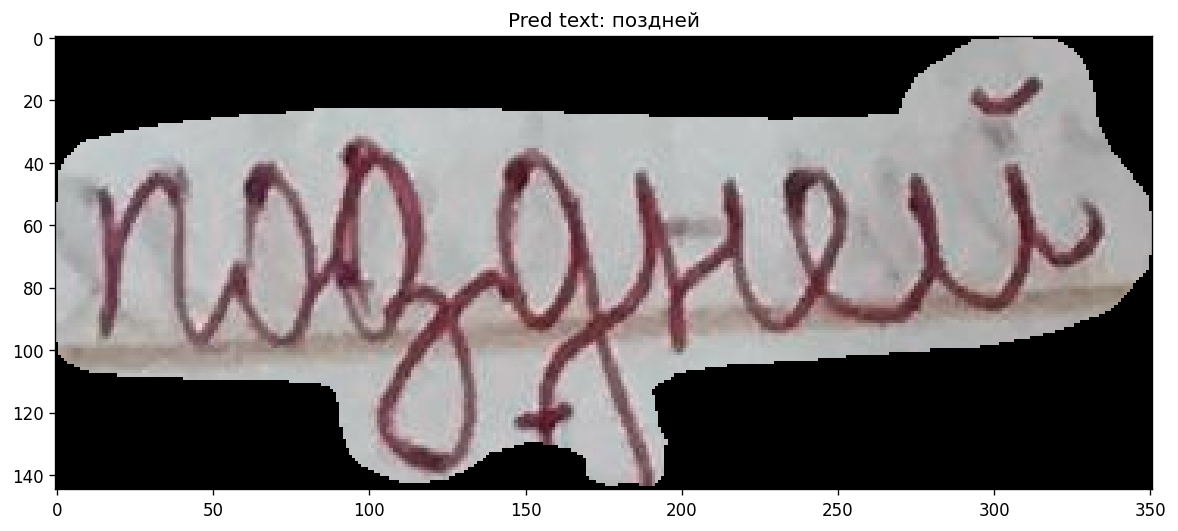

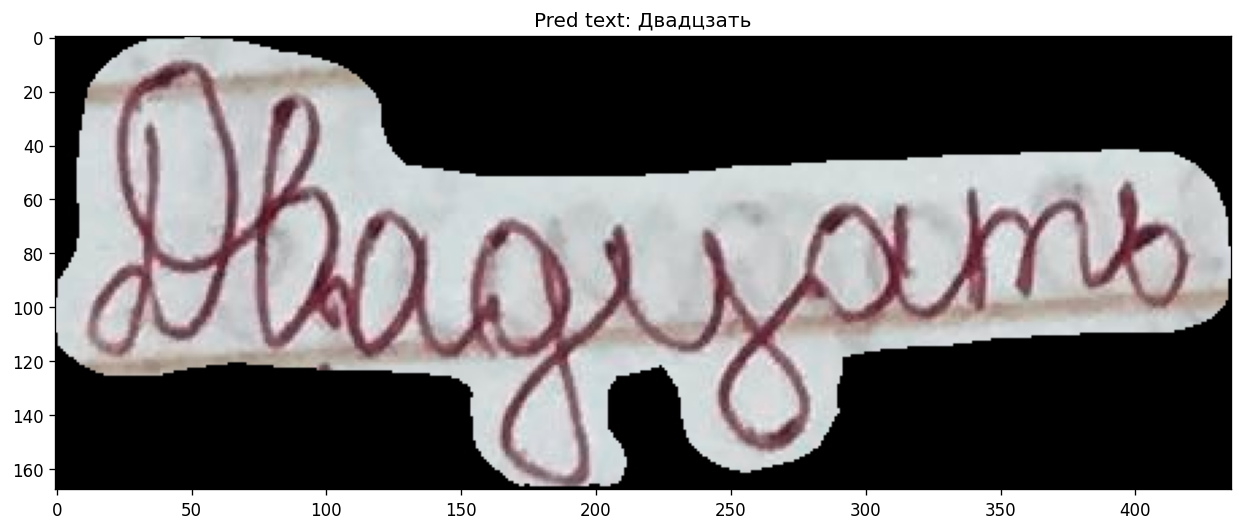

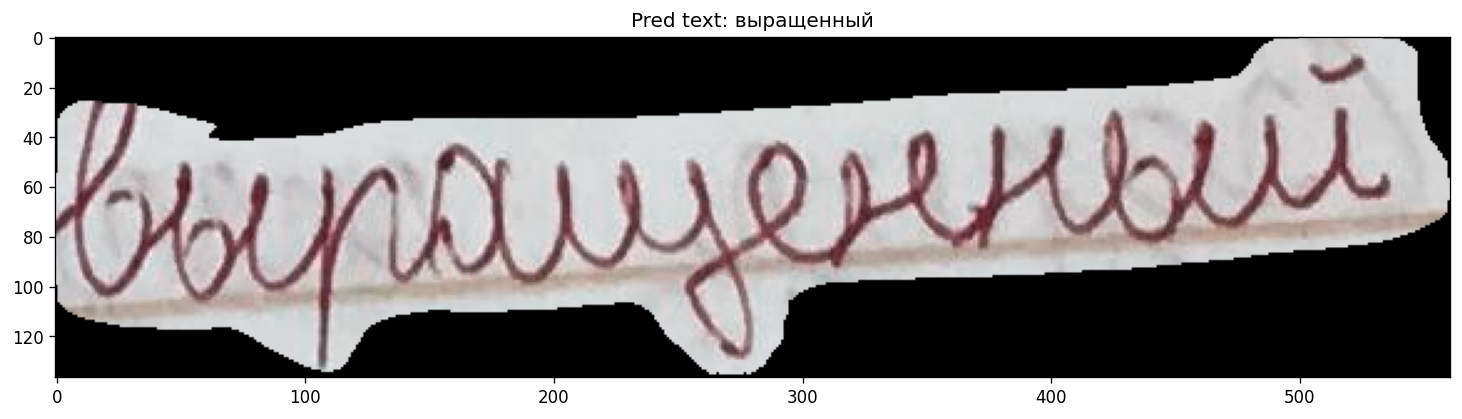

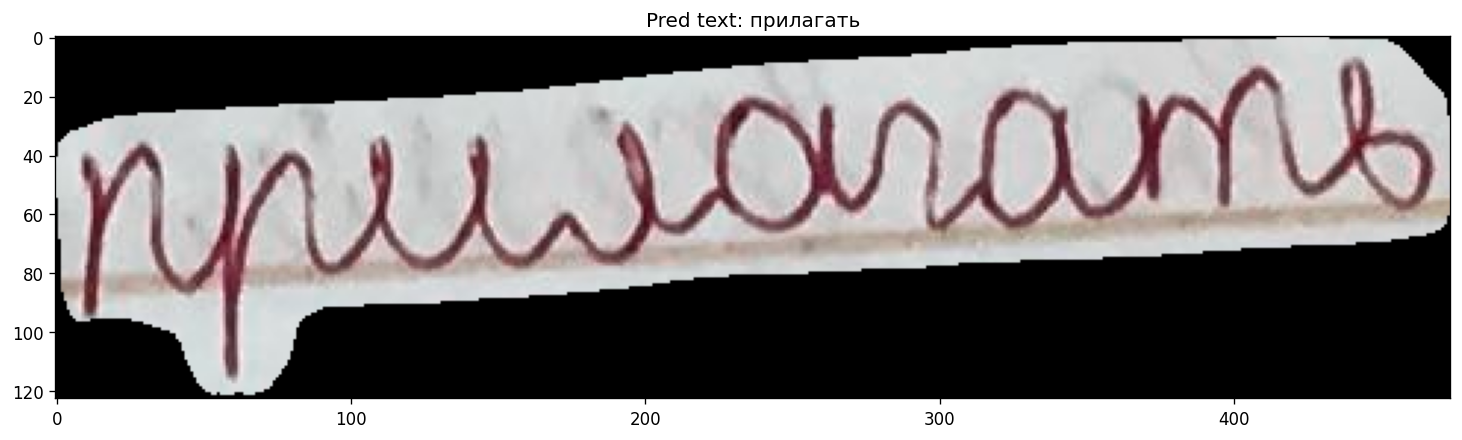

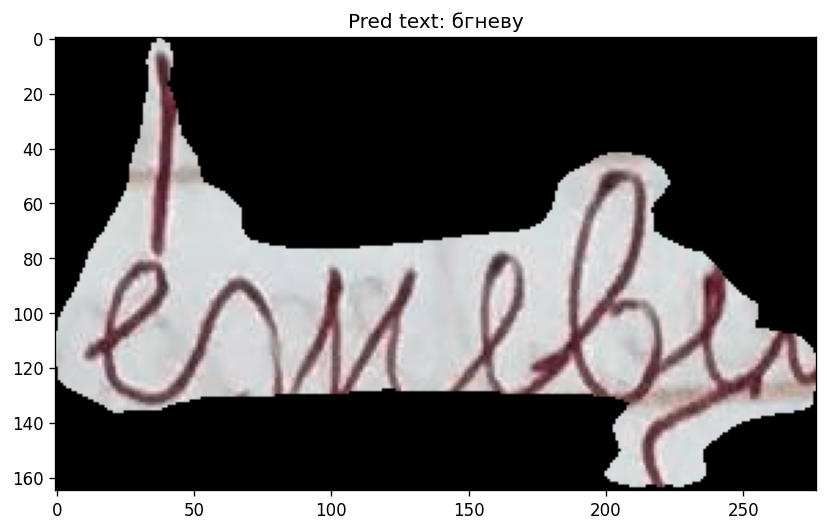

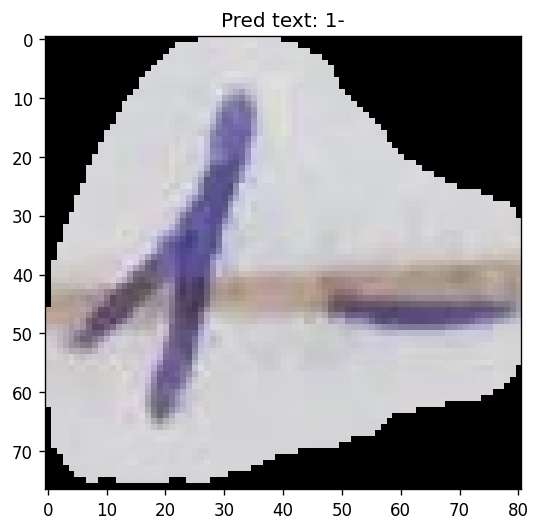

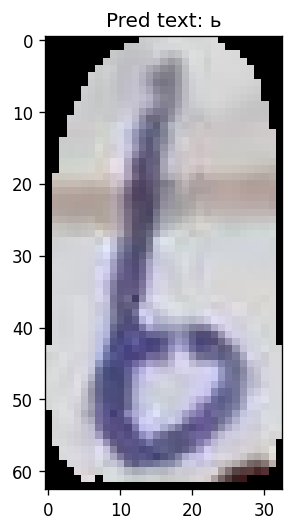

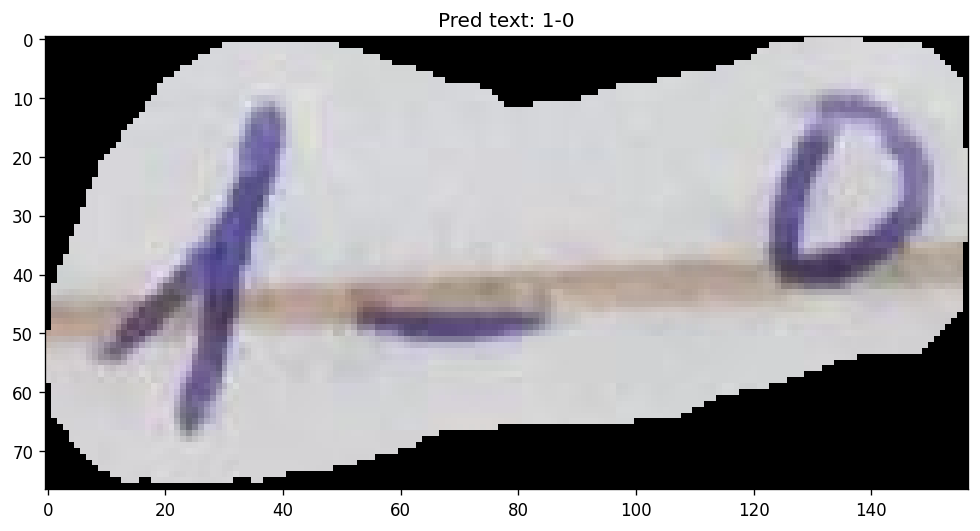

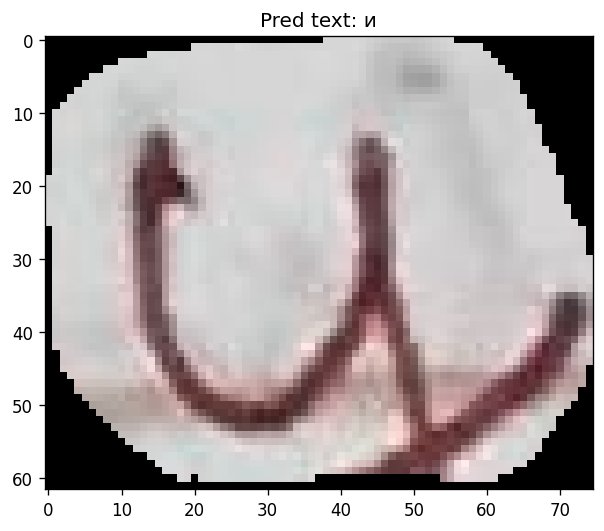

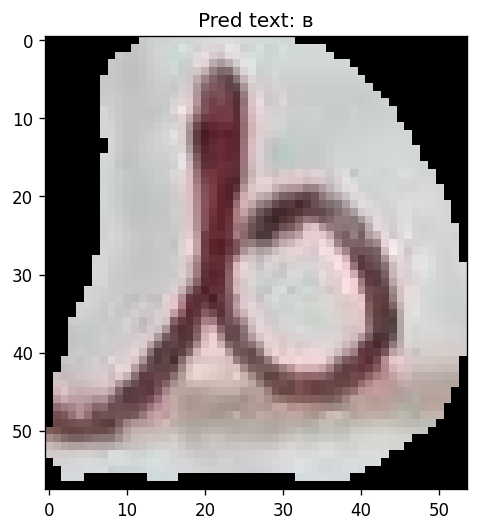

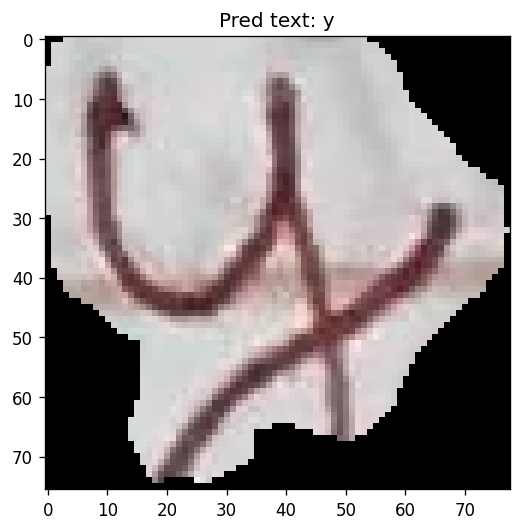

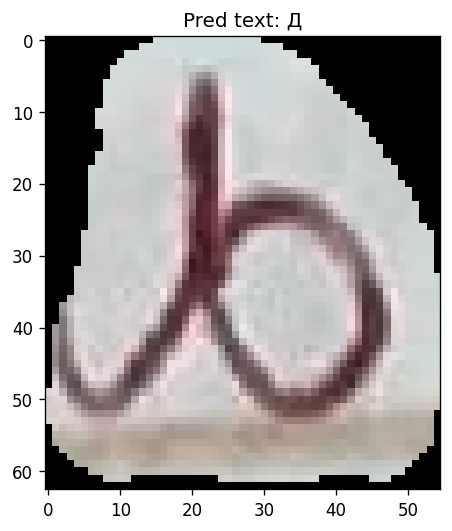

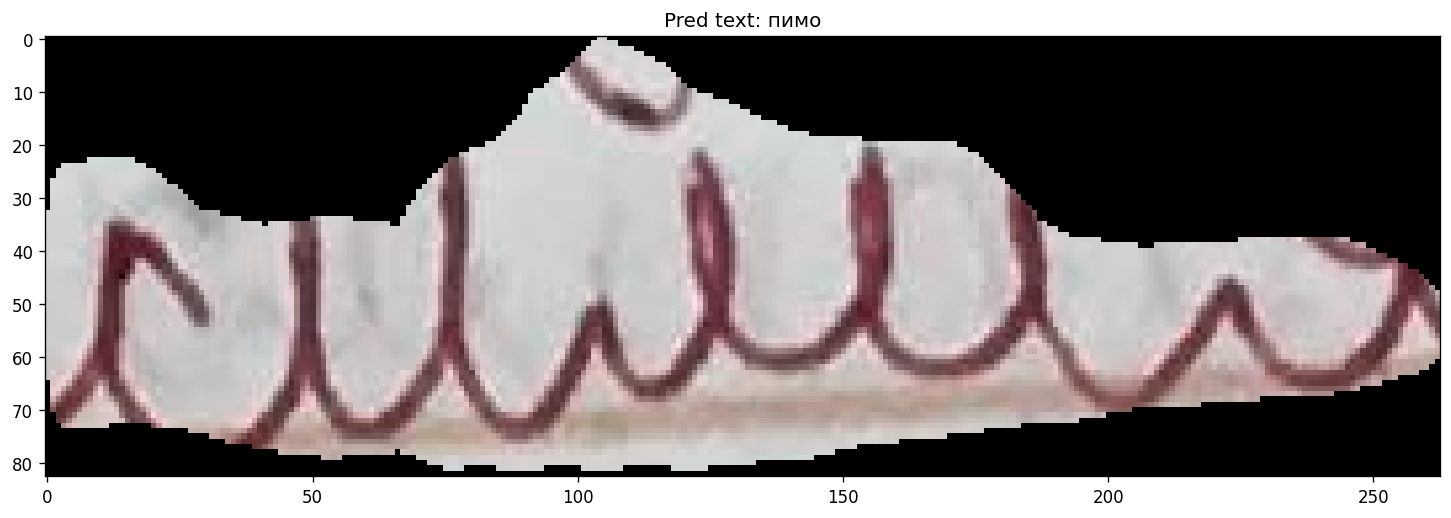

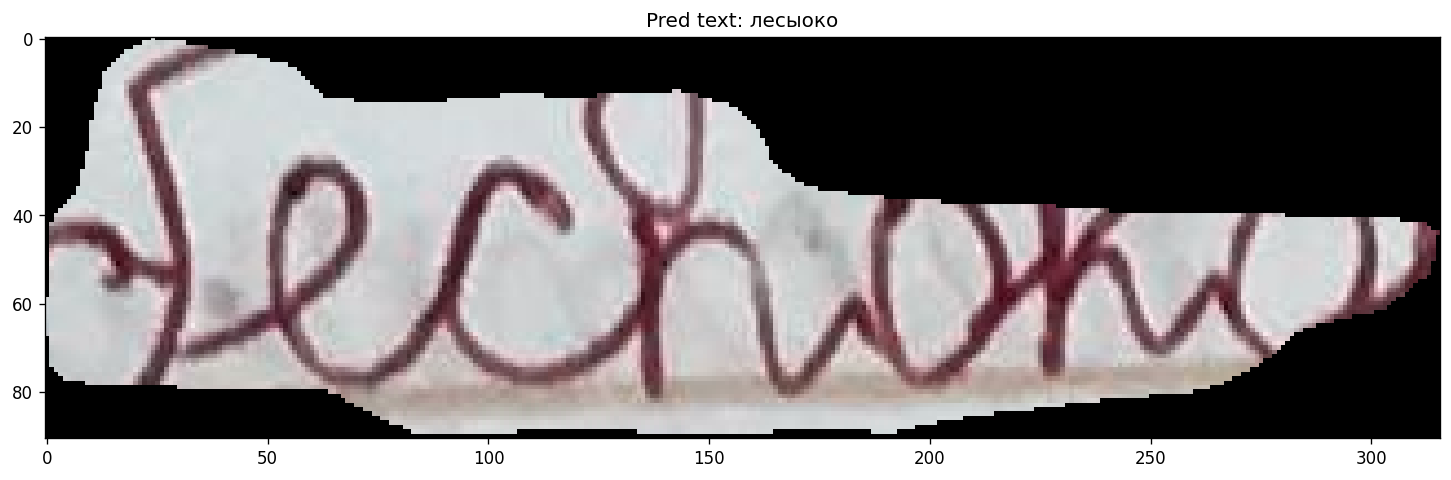

In [9]:
eval_img('test-bench/images/41_0.JPG')

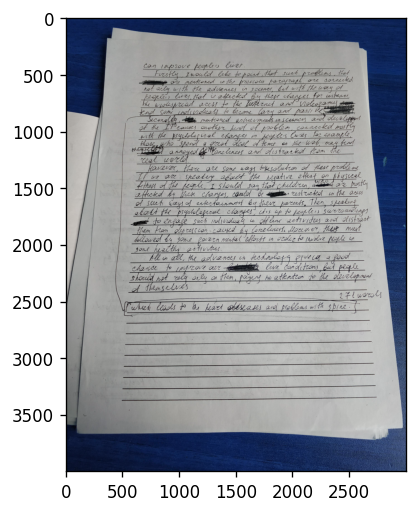

227 found on this image


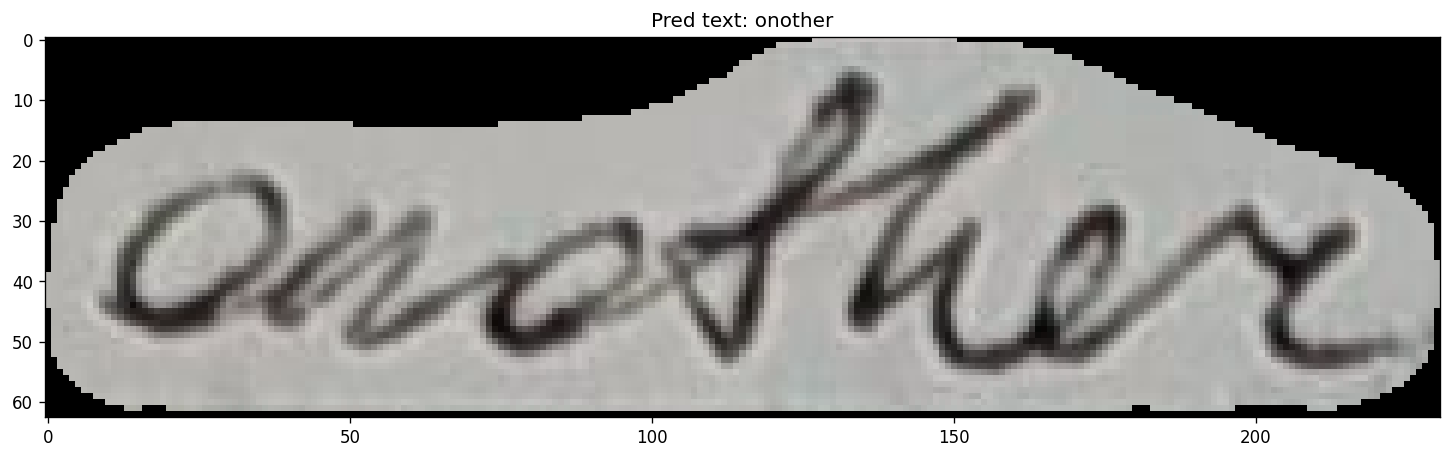

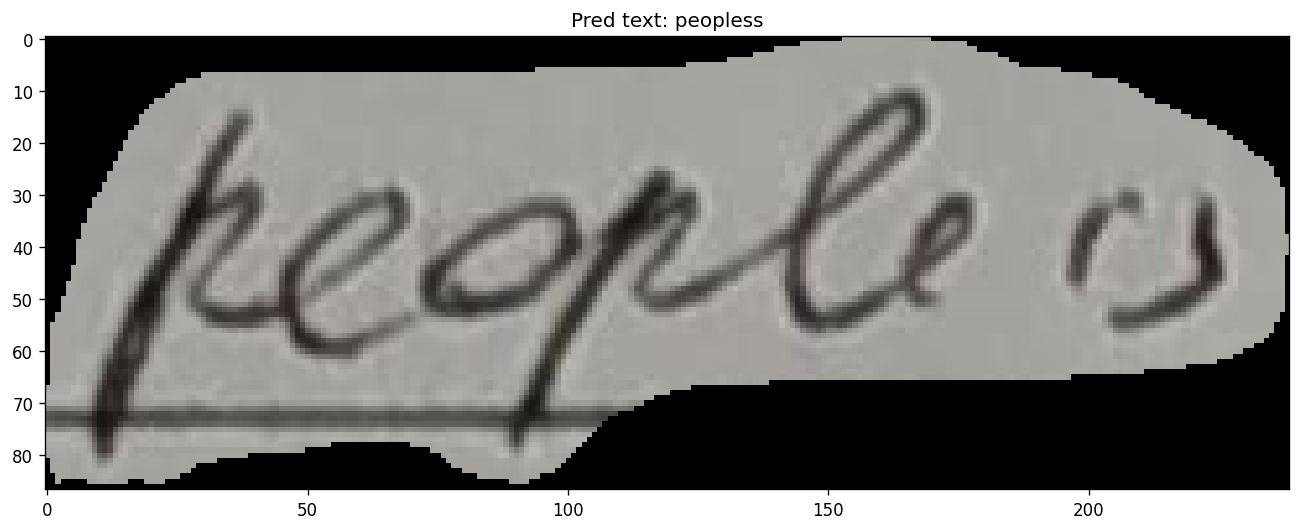

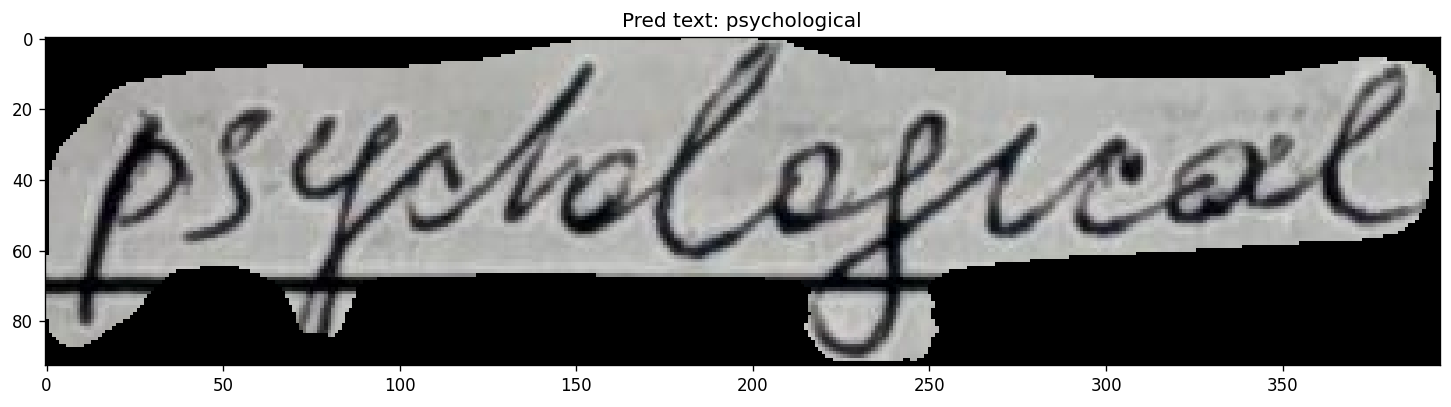

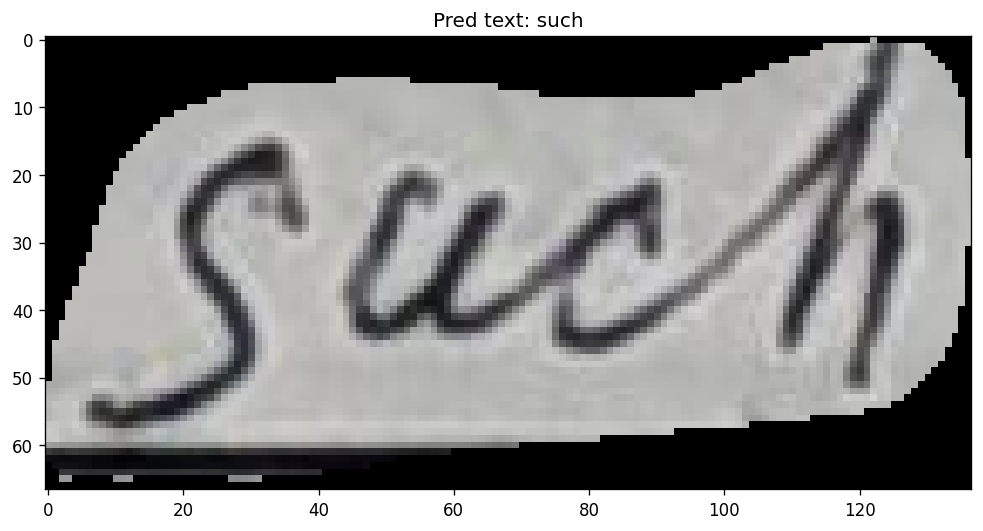

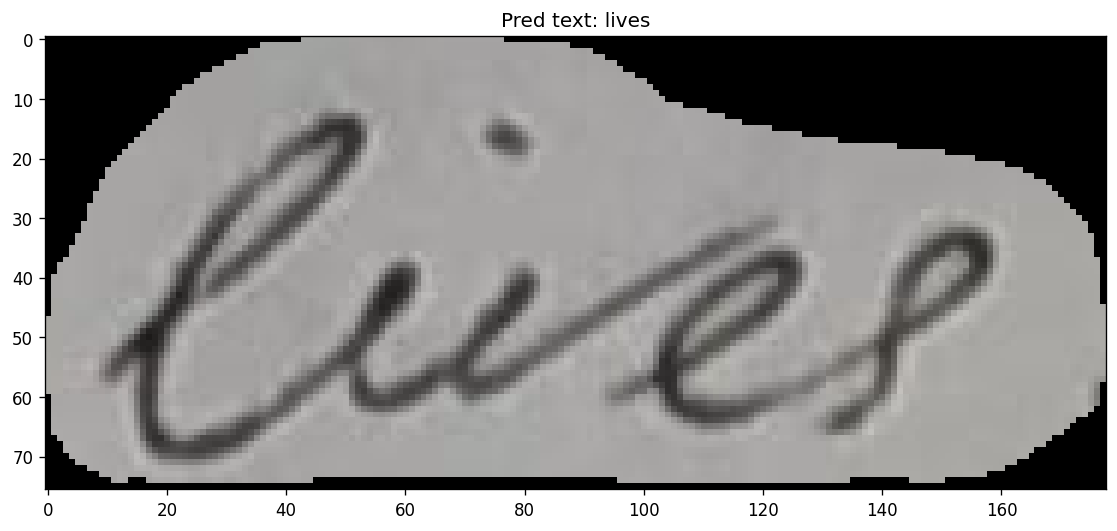

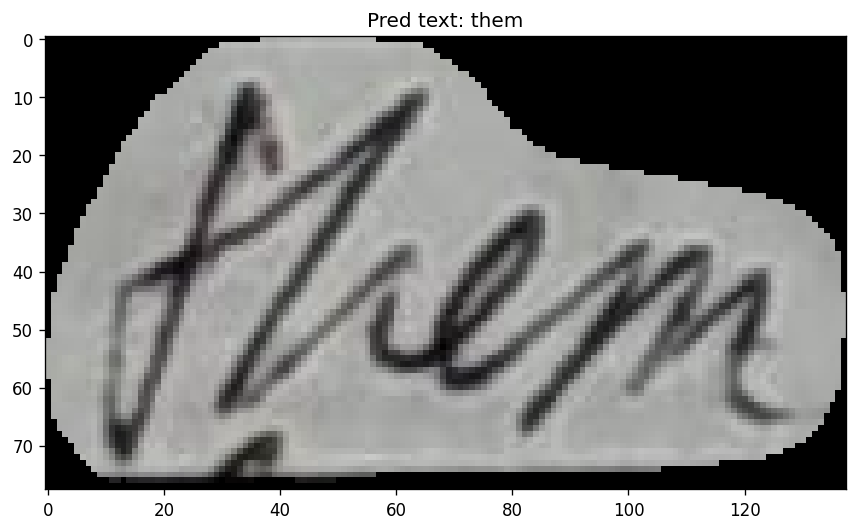

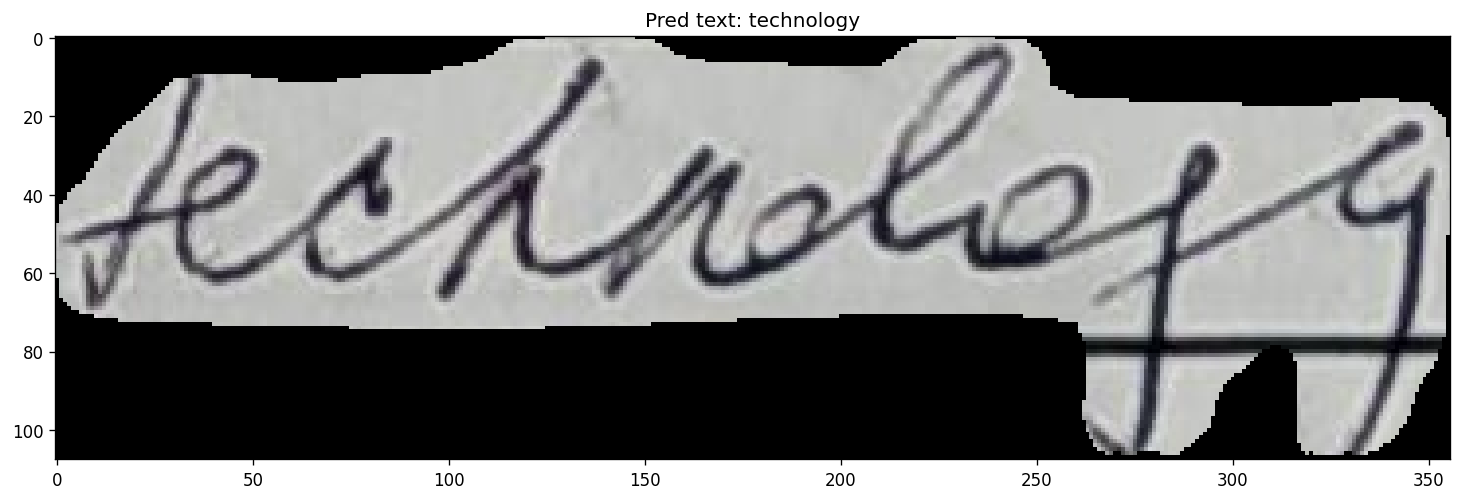

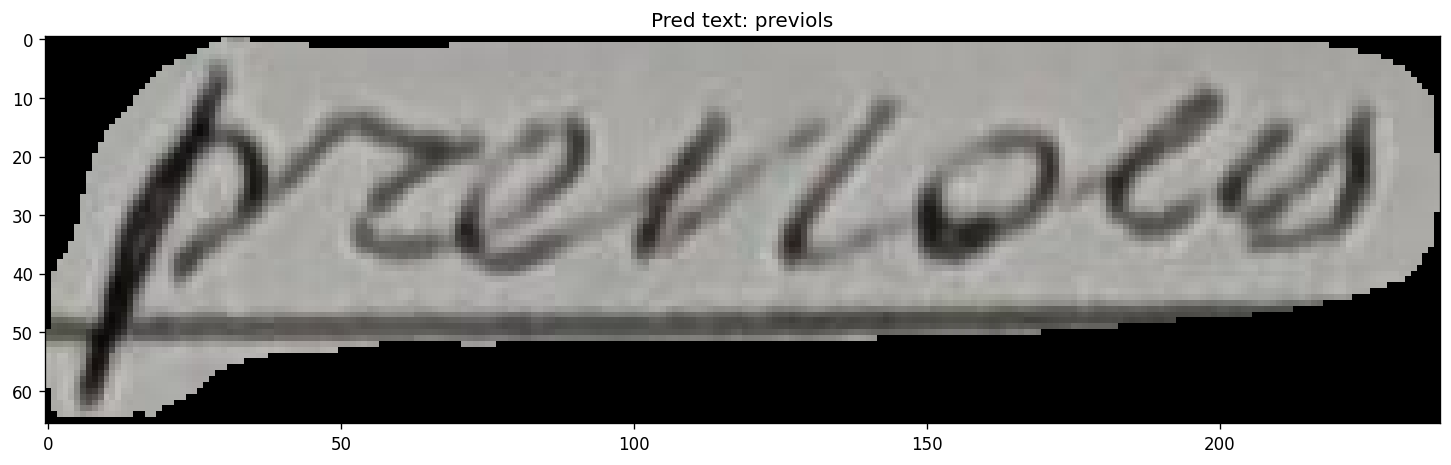

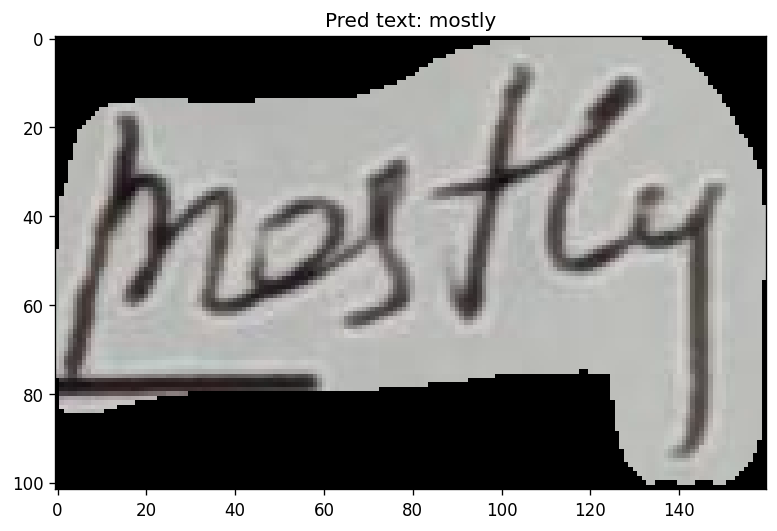

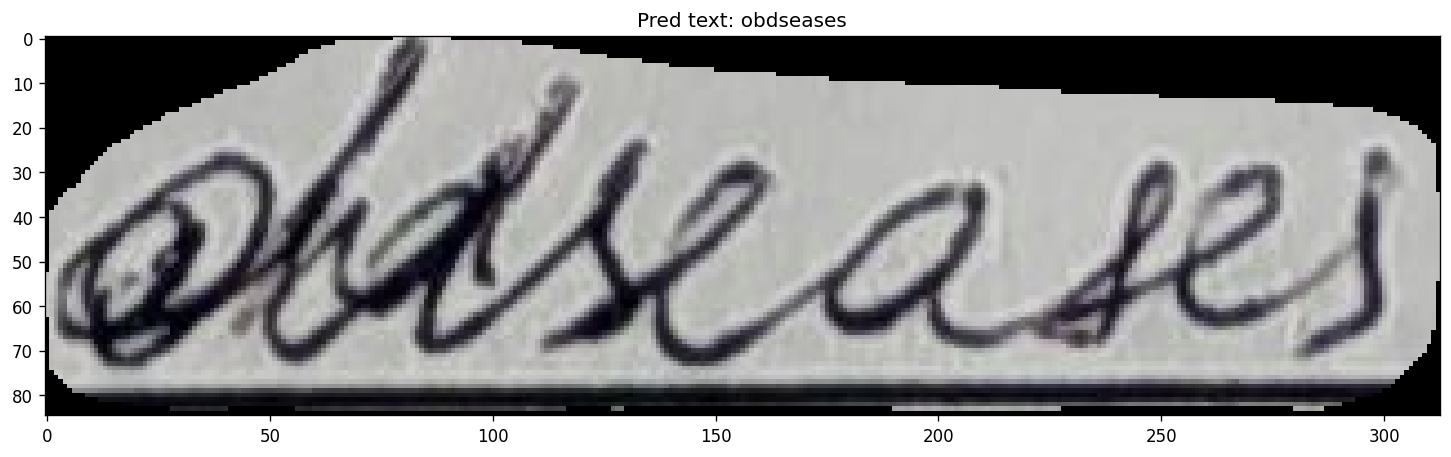

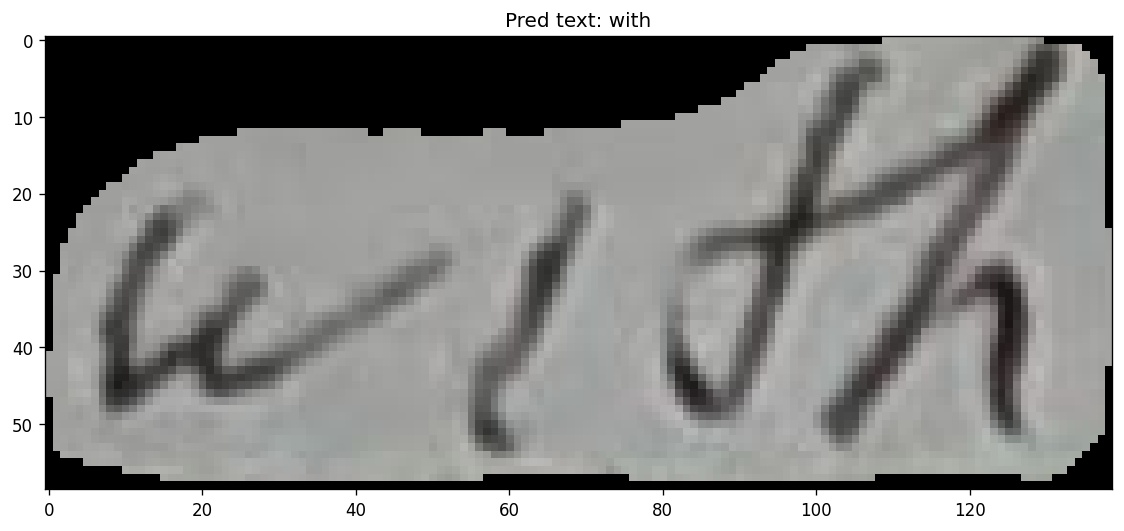

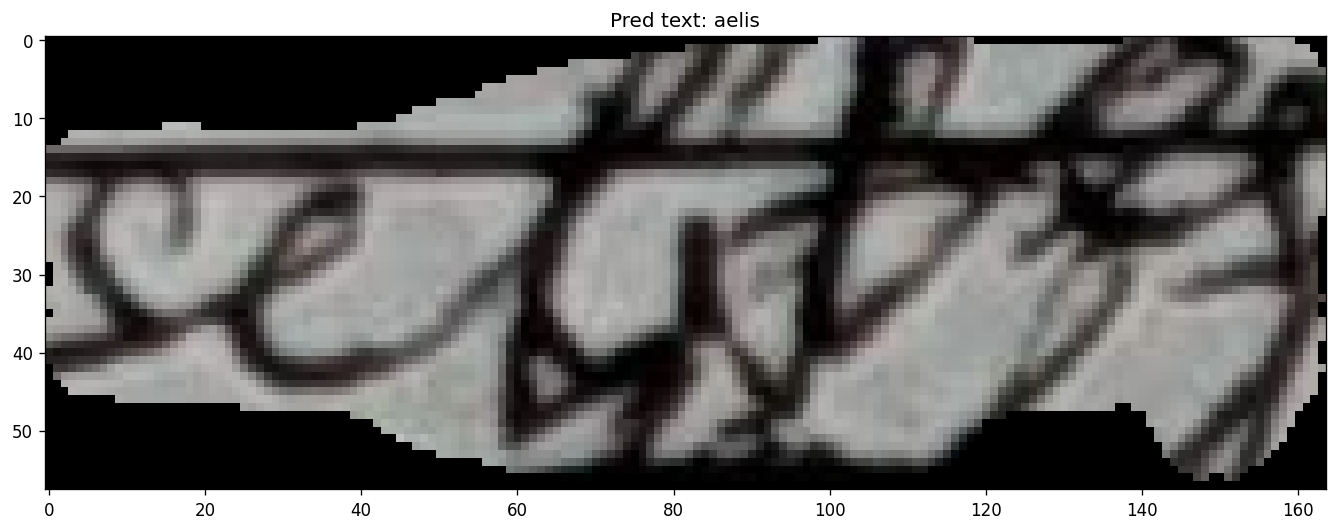

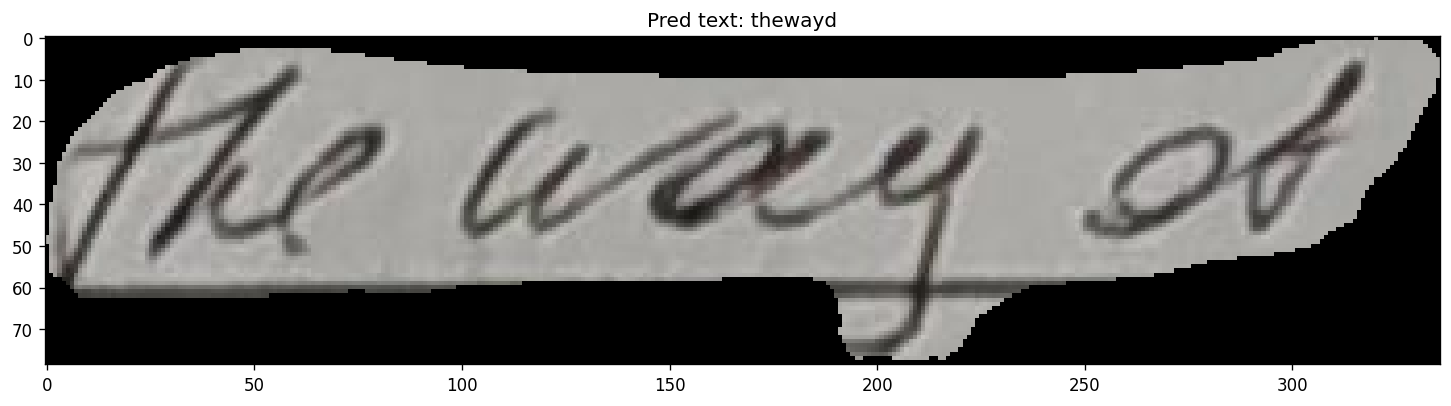

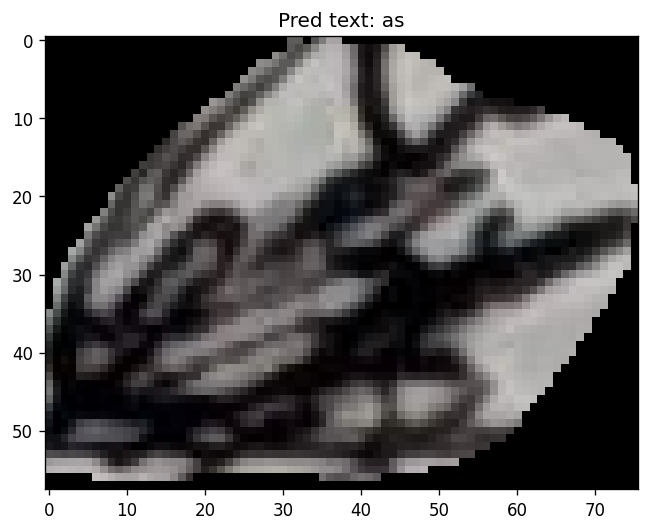

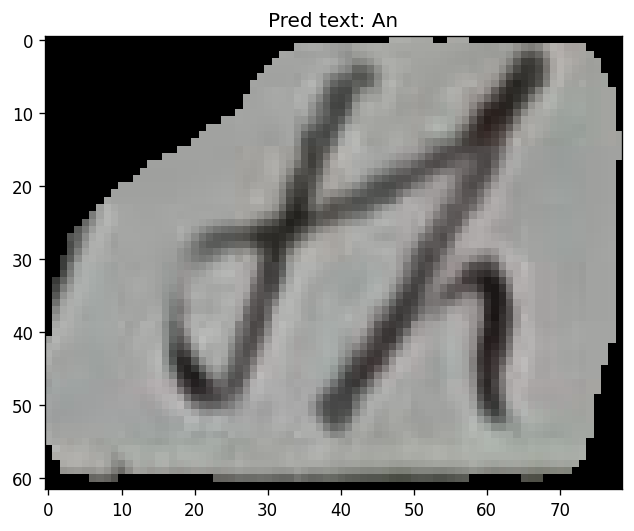

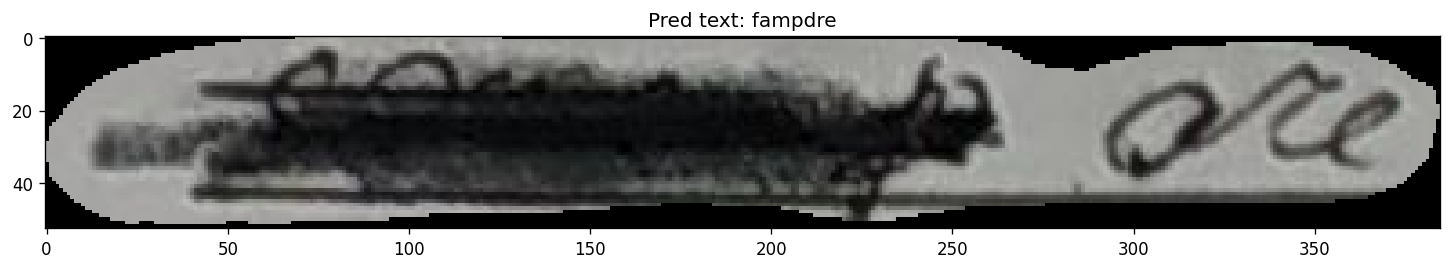

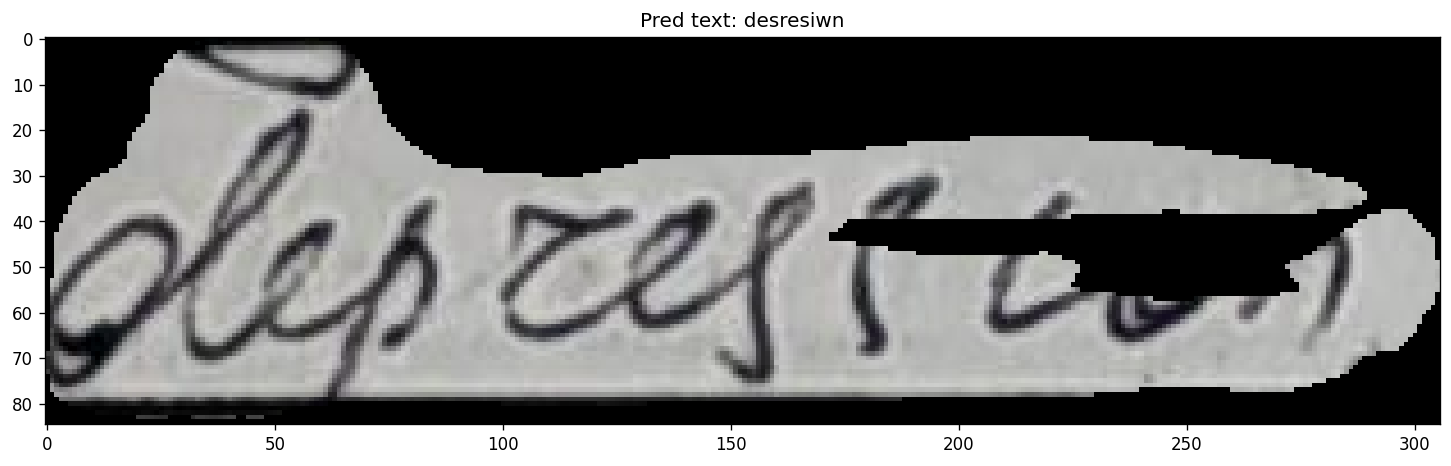

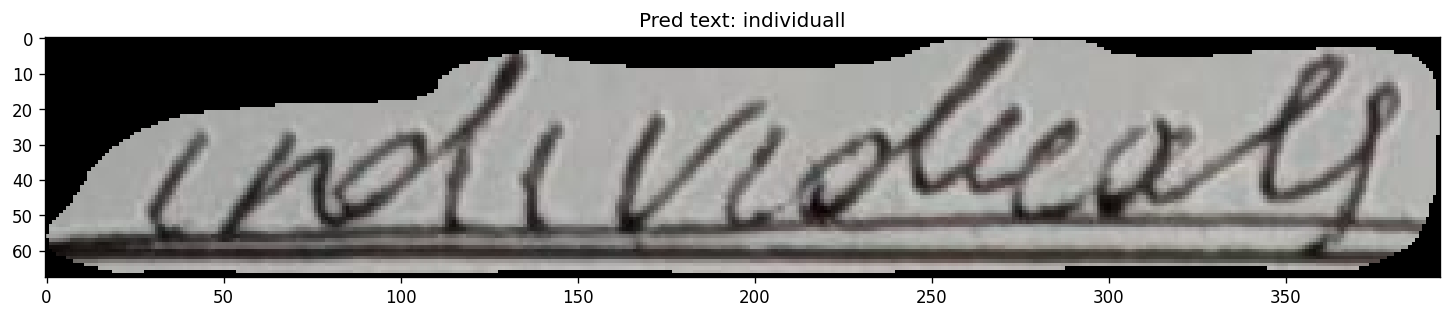

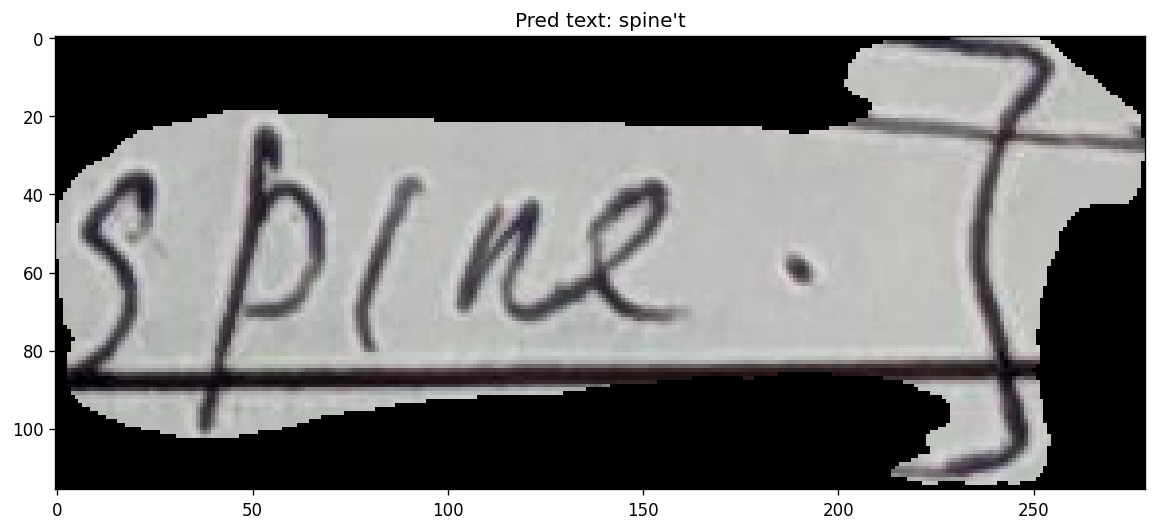

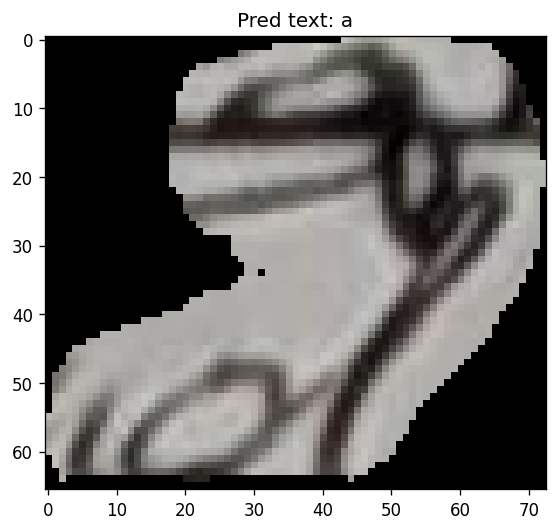

In [10]:
eval_img('test-bench/images/0_0_eng.jpg')

# Russian only model on eng

In [11]:
ru_model_config = {
  "alphabet": " !\"#$%&'()*+,-./0123456789:;<=>?@[\\]^_`{|}~«»ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№",
  "image": {
    "width": 256,
    "height": 32
  }
}
rec_model = OcrPredictor(model_path='test-bench/best-qual-recognition-ru-model.pth', config=ru_model_config)

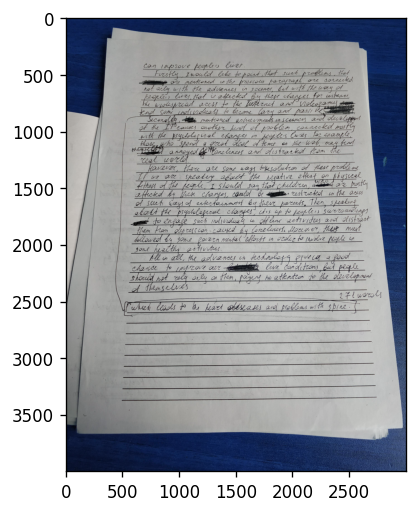

227 found on this image


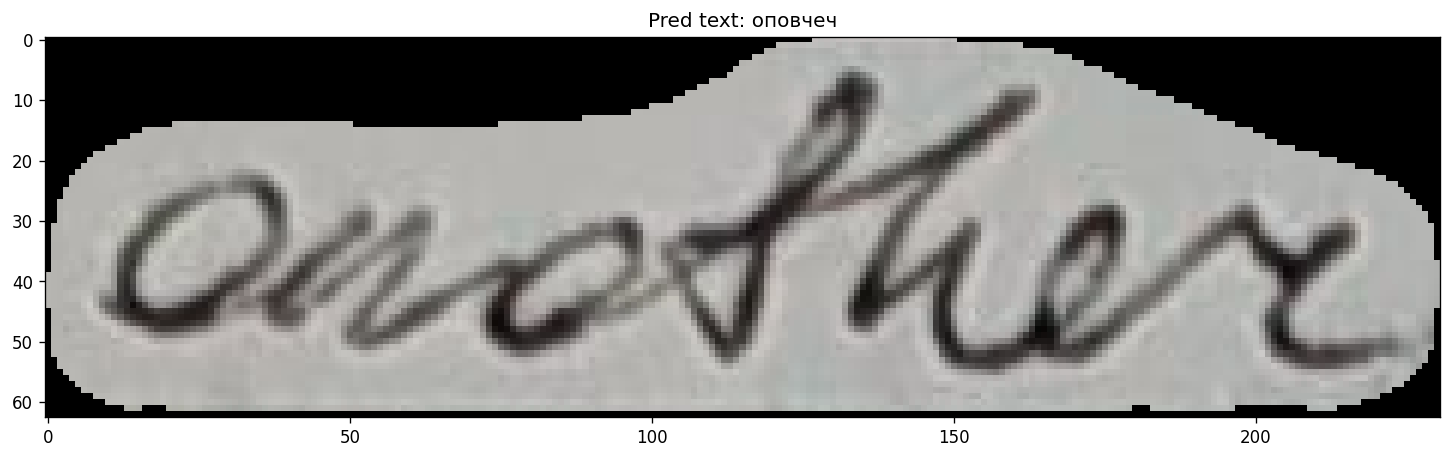

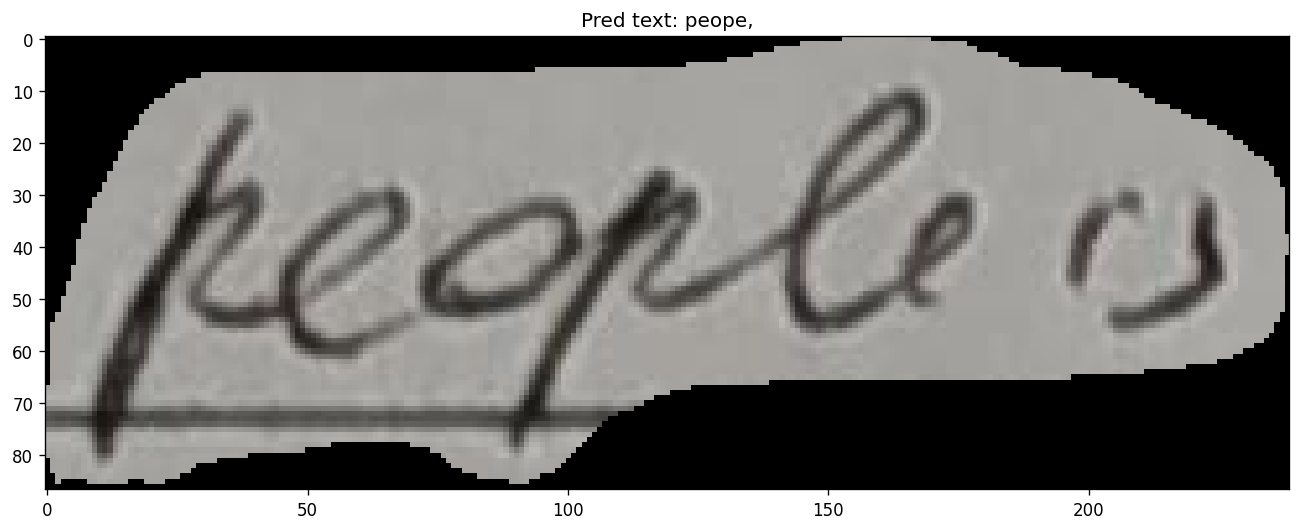

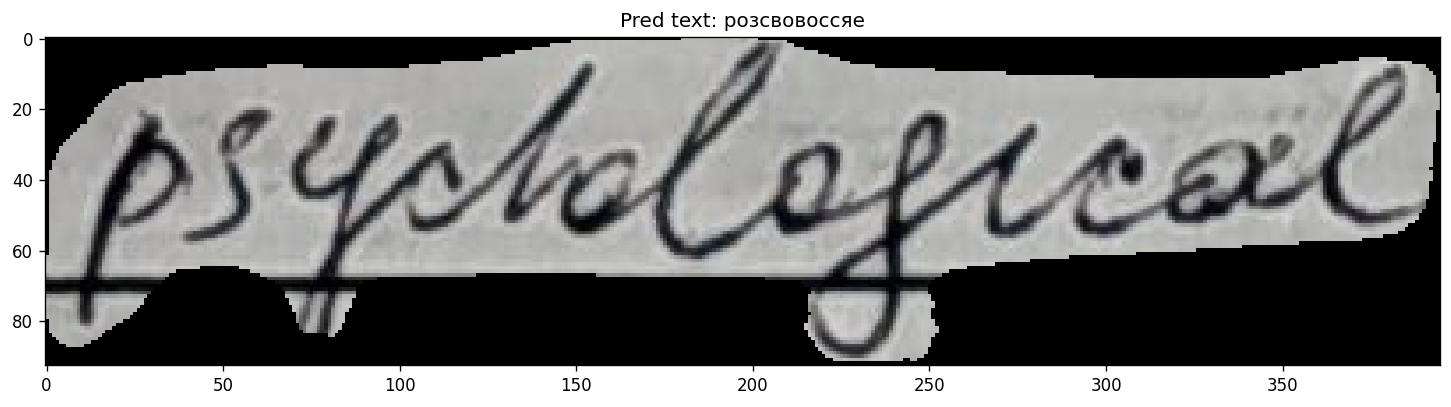

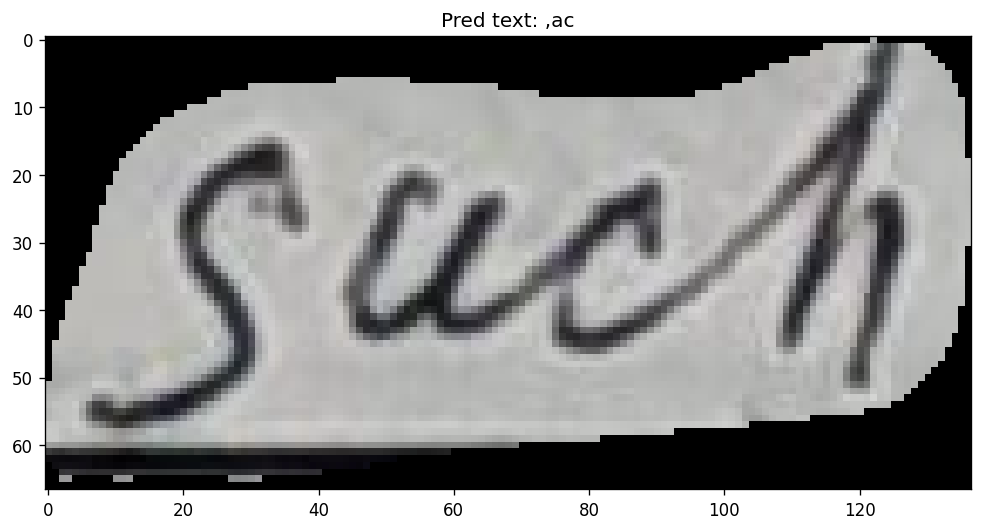

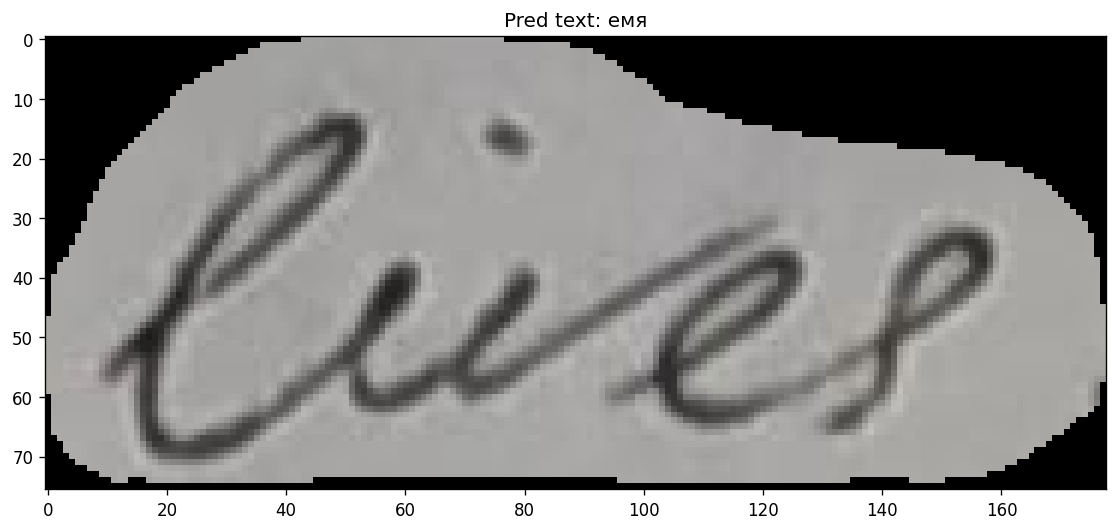

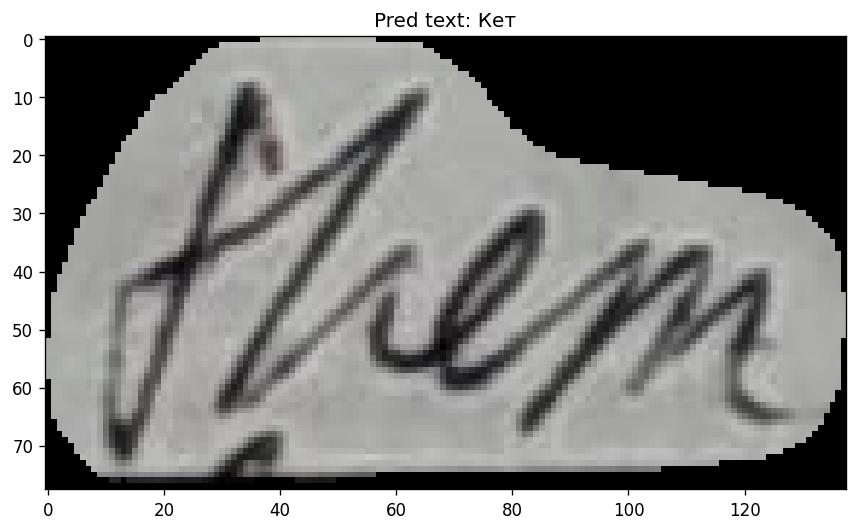

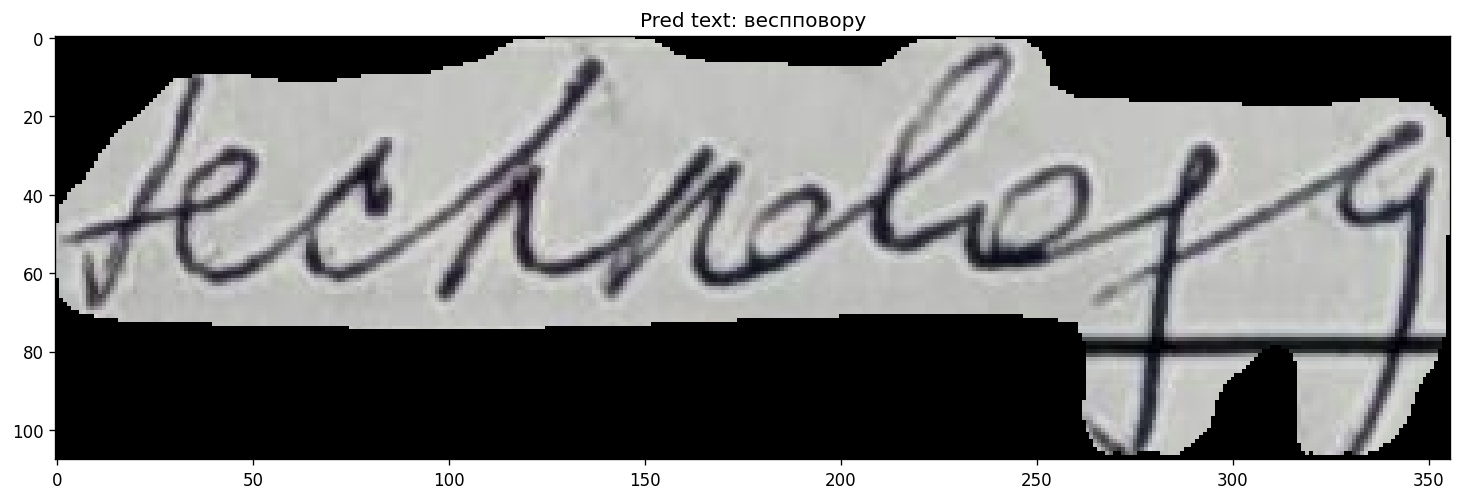

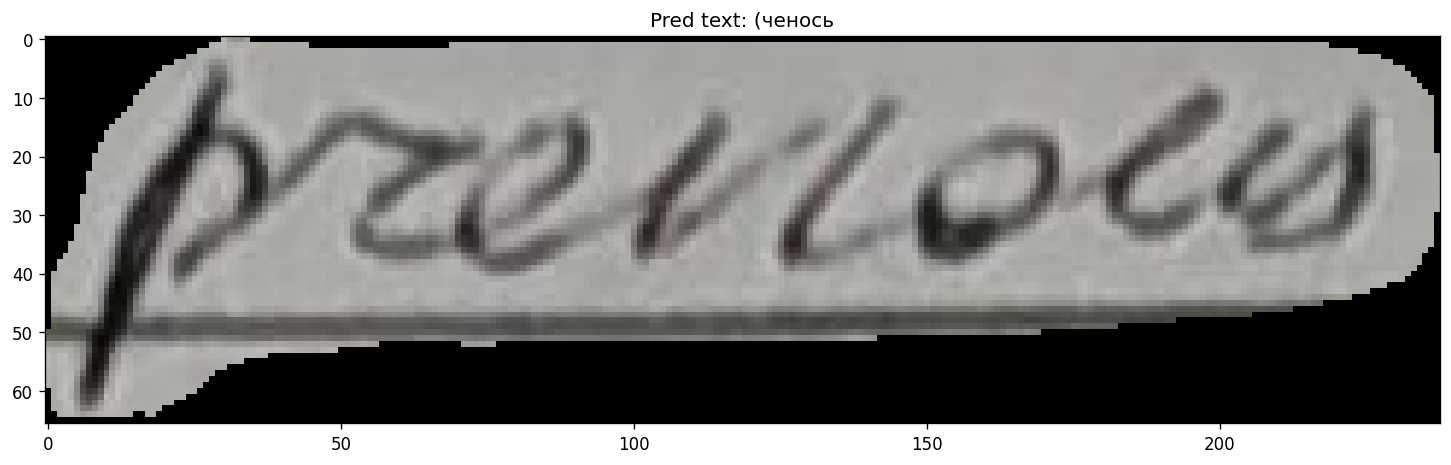

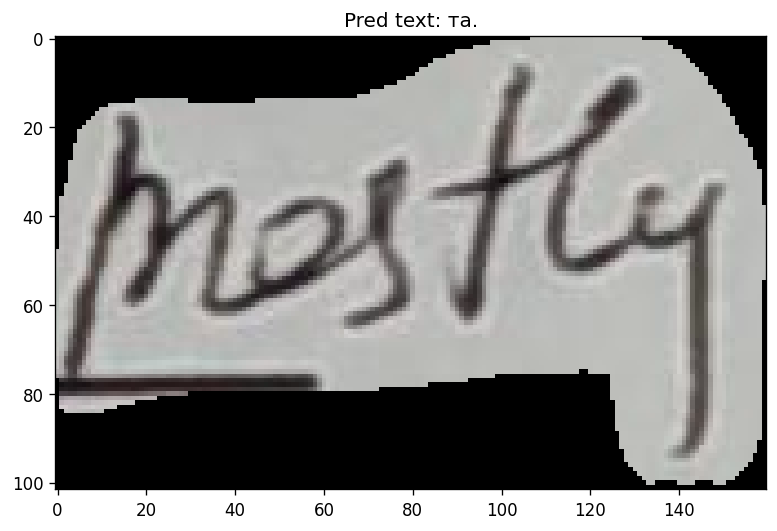

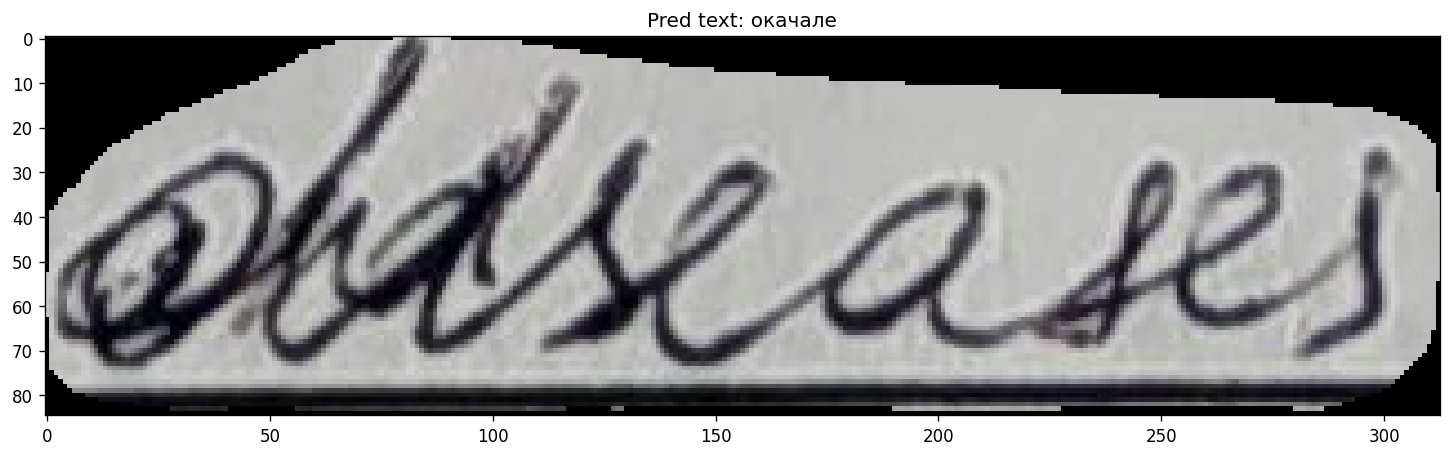

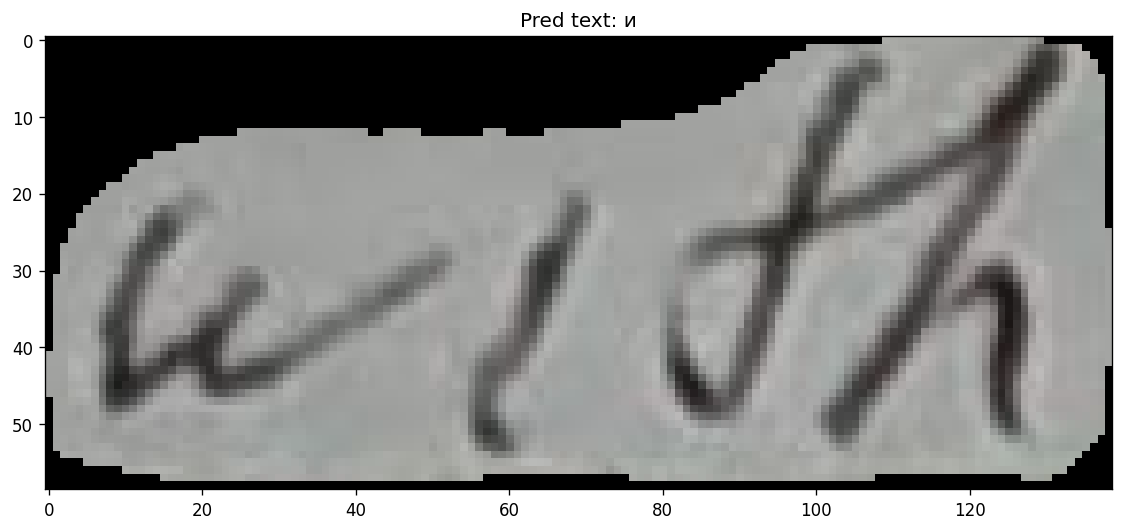

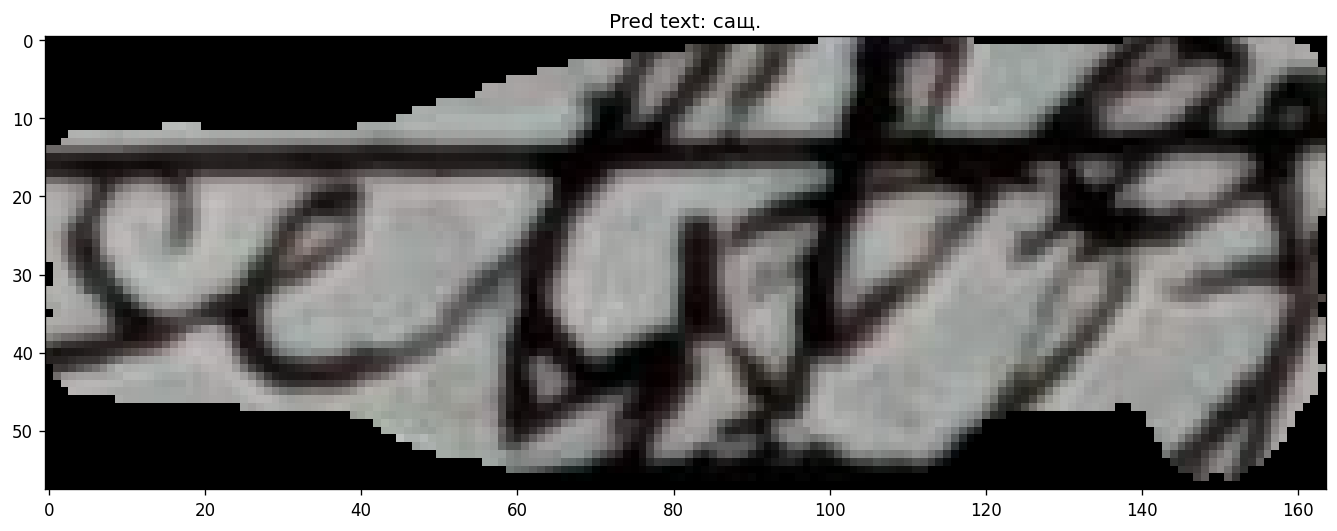

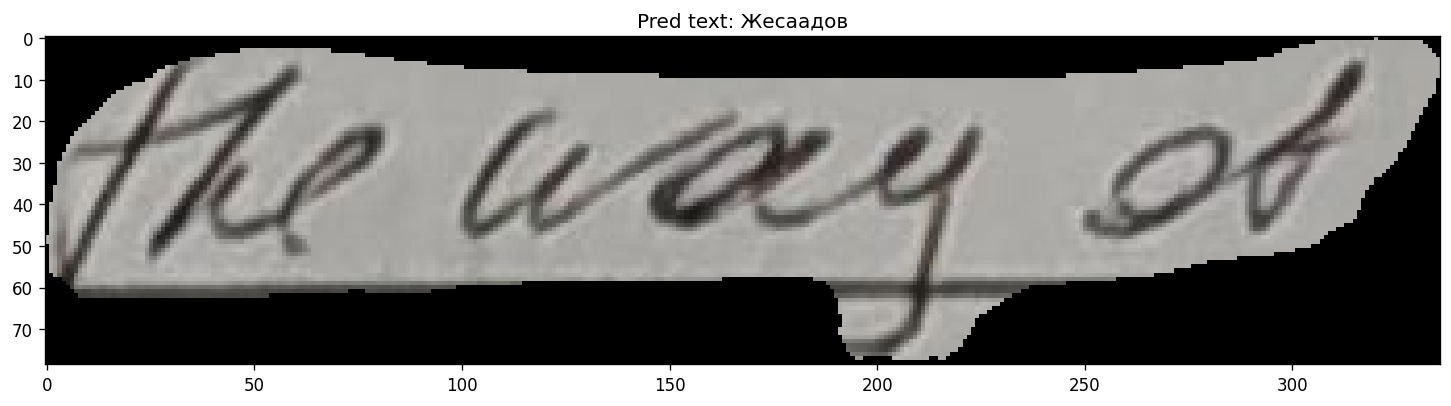

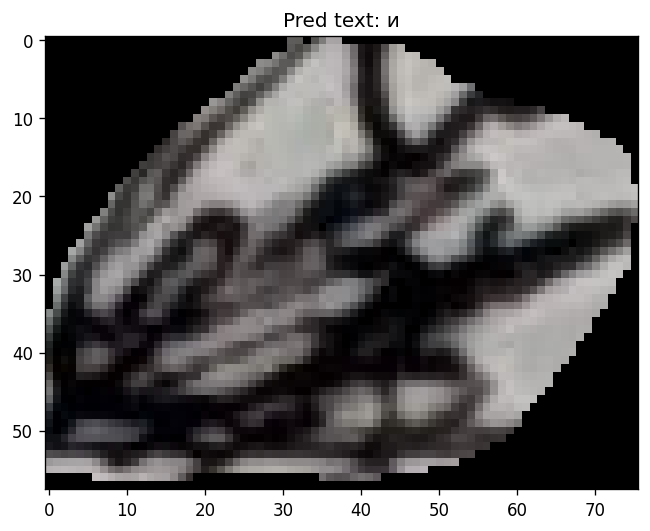

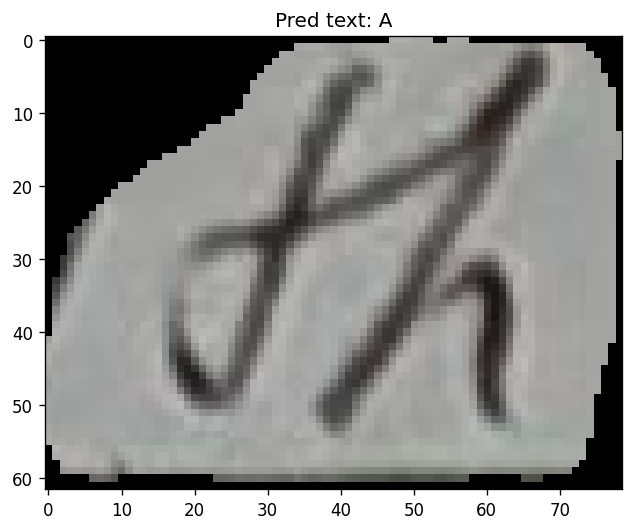

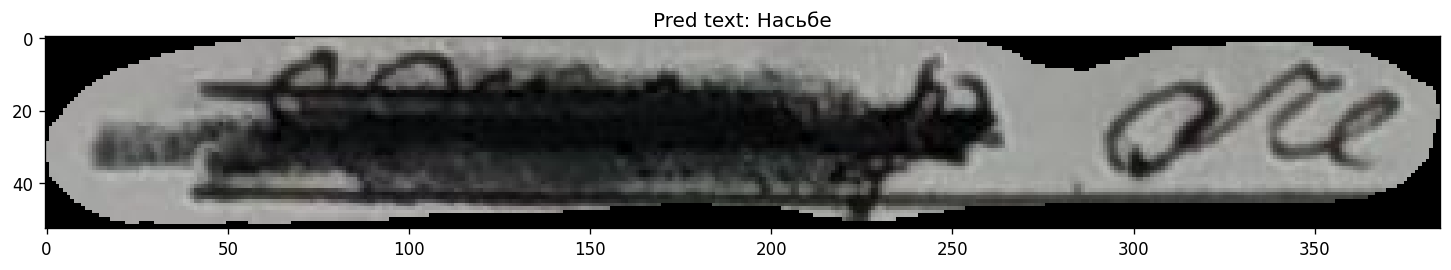

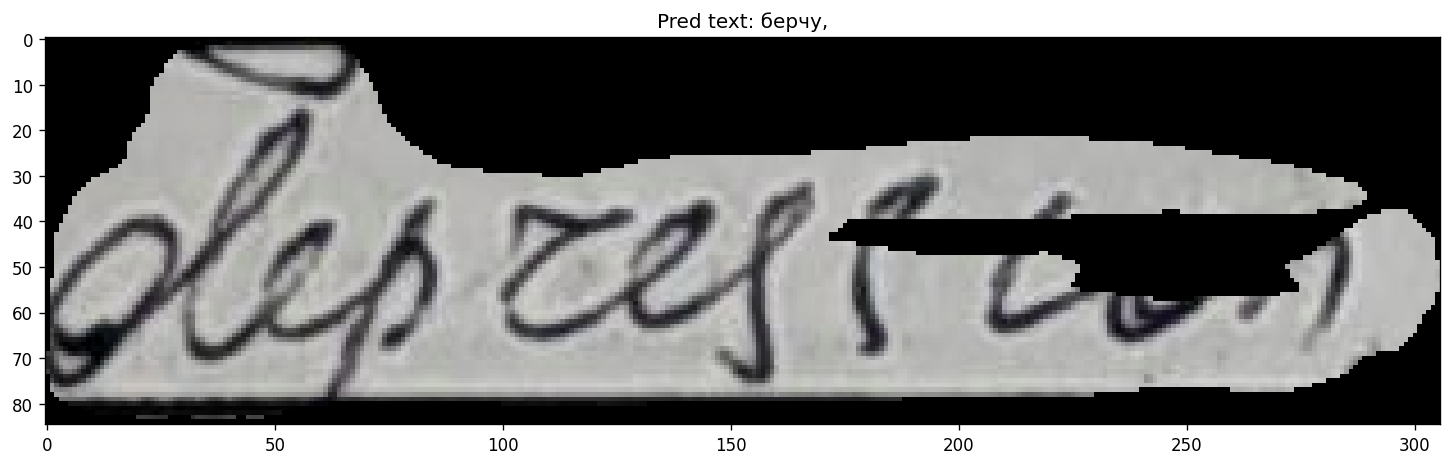

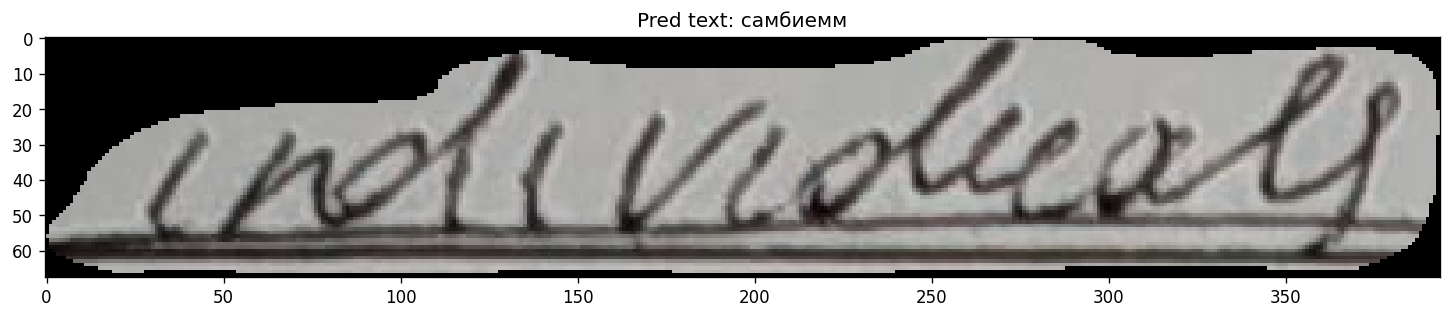

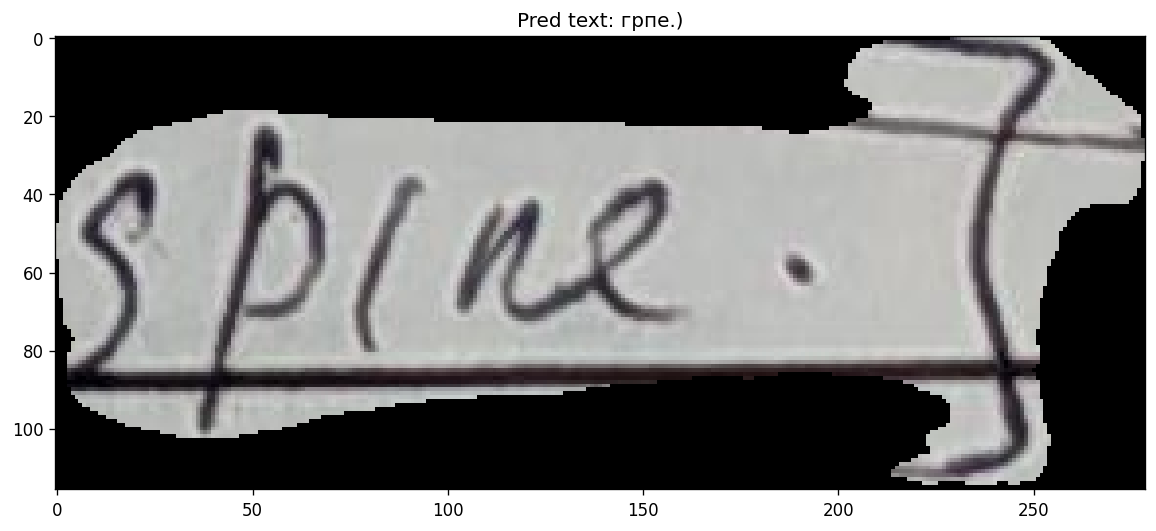

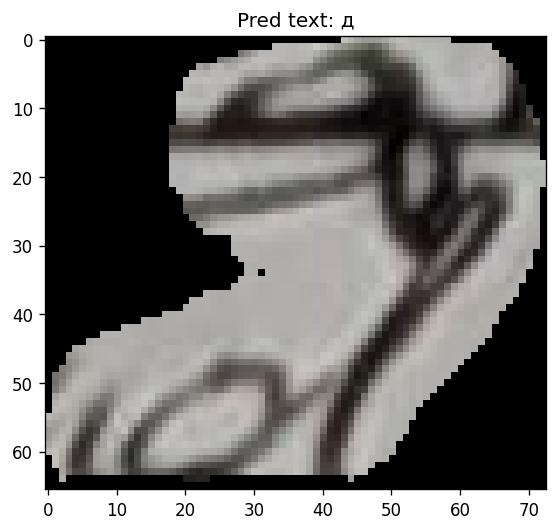

In [12]:
eval_img('test-bench/images/0_0_eng.jpg')